<style>
    div.output_wrapper {
      line-height: 1em; padding: 0;
      font-size: 1.2em;
    }
</style>


# Demonstration Informed Specification Search: Experiment

Let's take a look at how the DISS algorithm can search for specifications by leveraging expert demonstrations. 
We'll focus on learning DFAs in this case, but note that this approach is not confined to any specific concept class. To start consider an agent operating in the following stochastic gridworld.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_1.svg"
         style="height: 25em;"
     />
</figure>

## Agent Actions

The agent can attempt to move up, down, left, or right as illustrated below.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_2.svg"
         style="height: 20em;"
     />
</figure>

## Stochastic Transitions

However, there is some small probability that the agent will slip downward do to wind!

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_3.svg"
         style="height: 20em;"
     />
</figure>



Let's assume the agent's task can be described in terms of the color's of the tiles. **What was the agent trying to do?**


## Probably avoiding the red tiles

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_4.svg"
         style="height: 20em;"
     />
</figure>

## Probably trying to reach yellow tile

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/enter_lava_augmented_5.svg"
         style="height: 20em;"
     />
</figure>

In this notebook, we will illustrate learning task representations (in the form of Deterministic Finite Automata, i.e. DFA) that can be learned incrementally and describe temporal tasks.

In particular, we shall consider a variation of the following gridworld from [this](https://mjvc.me/DISS/#/77) slide deck: Here the agent's task is a composition of three subtasks.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1.svg"
         style="height: 20em;"
     />
</figure>

Where each subtask is a regular language represented as a DFA.

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_2_1.svg"
         style="height: 20em;"
     />
</figure>

Further, we shall assume that the first two subtasks are a-priori known (say due to learning in another workspace), 
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_1_2.svg"
         style="height: 20em;"
     />
</figure>

and our task is to learn the third task given a partial demonstration.
<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>


# Preamble

In [59]:
from functools import lru_cache

import attr
import funcy as fn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bidict import bidict
from IPython.display import Image, display, SVG
import networkx as nx
import pydot
import pandas as pd

from collections import Counter

import dfa
from dfa.utils import find_subset_counterexample, find_equiv_counterexample
from dfa_identify import find_dfa, find_dfas

from diss.planners.product_mc import ProductMC
from diss.concept_classes.dfa_concept import DFAConcept
from diss.domains.gridworld_naive import GridWorldNaive as World
from diss.domains.gridworld_naive import GridWorldState as State
from diss import search, LabeledExamples, GradientGuidedSampler, ConceptIdException
from pprint import pprint
from itertools import combinations
from tqdm import tqdm_notebook
from tqdm.notebook import trange
from IPython.display import clear_output
from IPython.display import HTML as html_print
from functools import reduce

sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Set2')

## Let's first visualize our gridworld and a demonstration within the gridworld.

In [71]:
COLOR_ALIAS = {
    'white': 'white',
    'yellow': '#ffff00', 
    #'brown': '#ffb081',
    'red': '#ff8b8b',
    'blue': '#afafff', 
    'green' : '#8ff45d'
}


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, world):
    """Use sensor to create colored tile."""
    if (x, y) in world.overlay:
        color = world.overlay[(x,y)]

        if color in COLOR_ALIAS.keys():
            return tile(color)
    return tile('white')

In [73]:
from diss.experiment.vis import print_map, print_trc

gw = World.from_string(
    """
    y__
    g_b
    grb
    """,
    start=(3, 1),
    codec={'y': 'yellow', 'g': 'green', 'b': 'blue', 'r': 'red'},
    slip_prob = 1/32
)

demos = [gw.path([
   (3, 1),
    '←', 
    (3, 2),
    '←',
    (2, 2),
    '←',
    (1, 2),
   #'↑',
   #(1, 1),
])]

print_map(gw)
print_trc(demos[0], gw)

Compare against our target domain:

<figure style="padding: 1em; background: #494949;">
    <img src="imgs/example_domain_3_2.svg"
         style="height: 20em;"
     />
</figure>

# Search procedure

Now, we can define a set of expert demonstrations for this gridworld to guide our specification search procedure.

Let's start with some very simple base examples to warm-start our specification search process. We want to synthesize a spec that's consistent with the observed evidence thus far:

Going from the partial spec to a full spec :

In [4]:
from diss.experiment import PartialDFAIdentifier, ignore_white, PARTIAL_DFA, BASE_EXAMPLES
from diss.experiment import view_dfa

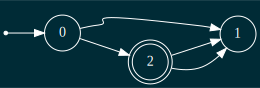

In [5]:
identifer = PartialDFAIdentifier(
    partial = PARTIAL_DFA,
    base_examples = BASE_EXAMPLES,
)
view_dfa(identifer(LabeledExamples()))

Now, we can outline the machinery for the search process itself. We use the solution procedure in the DFA identification algorithm to synthesize a minimal DFA (in both states and non-stuttering edges) that is consistent with the observed examples to this point. 

# Simulated Annealed + SGGS

In [6]:
from diss import diss

In [7]:
def lift_path(path):
    return ignore_white(map(gw.sensor, path))

In [8]:
class ProductMC2(ProductMC):
    def sample(self, pivot, win, attempts=20):
        # Sample until you give a path that respects subset properties.
        for i in range(attempts):
            result = ProductMC.sample(self, pivot, win)
            if win or (result is None):
                return result

            # Don't let conjecture violate subset constraint.
            word = lift_path(result[0])
            if ('yellow' in word) and ('red' not in word):
                return result

In [9]:
@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    chain = ProductMC.construct(
        concept=c, tree=t, dyn=gw, max_depth=9,
        psat=0.8, sensor=gw.sensor, xtol=0.05
    )
    return ProductMC2(chain.tree, chain.concept, chain.policy, chain.tree2policy)

In [10]:
test_words = LabeledExamples(
    positive=[
        ('blue', 'green', 'yellow'),
        ('green', 'yellow'),
    ],
    negative=[
        ('green', 'blue', 'yellow'),
        ('blue', 'yellow'),
    ]
)

In [11]:
def brier_score(concept2energy):
    pmf = np.array([np.exp(-u) for u in concept2energy.values()])
    pmf /= pmf.sum()
    
    p_accept, bs = {}, 0
    for word in test_words.unlabeled:
        oracle_lbl = word in test_words.positive
        votes = np.array([(word in c) for c in concept2energy])
        p_accept[word] = pmf @ votes
        print(word, p_accept[word])
        bs += (oracle_lbl - p_accept[word])**2
    return bs / test_words.size

In [12]:
def analyze(search, n_iters):
    poi = set()            # Paths of interest.
    concept2energy = {}    # Explored concepts + associated energy
    partial_masses = []
    brier_scores = []
    # 1. Run Search and collect concepts, energy, and POI.
    for _, (data, concept, metadata) in zip(trange(n_iters, desc='DISS'), search):
        pprint(metadata)
        concept2energy[concept] = metadata['energy']
        poi |= data.unlabeled
        view_dfa(concept)
        partial_masses.append(sum(np.exp(-x) for x in concept2energy.values()))  # Record unormalized mass
        brier_scores.append(brier_score(concept2energy))

    # 2. Add distiguishing words to POI.
    to_distinguish = combinations(concept2energy, 2)
    poi |= {c1.seperate(c2) for c1, c2 in to_distinguish}

    # 3. Build CMF, PMF, and compute normalizing constant.
    sorted_concepts = sorted(list(concept2energy), key=concept2energy.get)
    pmf = np.array([np.exp(-concept2energy[c]) for c in sorted_concepts])
    Z = pmf.sum()
    pmf /= Z
    cmf = np.cumsum(pmf)

    for p, c in zip(pmf, sorted_concepts):
        print(f'prob = {p:.3}'
              f'energy = {concept2energy[c]:.3}'
              f'size = {c.size:.3}')
        view_dfa(c)

    # 4. Plot CDF of distribution.
    sns.lineplot(x=list(range(len(cmf))), y=cmf)
    plt.xlabel('DFA index (sorted by probability mass)')
    plt.ylabel('CMF')
    plt.show()

    # 5. Compute current support's belief on POI
    p_accept = {}
    for word in poi:
        votes = np.array([(word in c) for c in sorted_concepts])
        p_accept[word] = pmf @ votes
    grouped = fn.group_by(lambda w: p_accept[w] > 1/2, poi)
    buff = ''
    for lbl in [True, False]:
        buff += f'------------- {lbl} --------------<br>'
        split = sorted(grouped[lbl], key=lambda x: -p_accept[x])
        for word in split:
            obs = '\n'.join(map(tile, word))
            buff += f'{p_accept[word]:.2}:'.ljust(9, 'X').replace('X', '&nbsp')
            buff += f'{obs}<br>'
    display(html_print(buff))

    # 6. Print DFAs consistent with thresholded belief on POI.
    accepting, rejecting = set(), set()
    for word in poi:
        belief = p_accept[word]
        if belief > 0.9:
            accepting.add(word)
        elif belief < 0.1:
            rejecting.add(word)
    data = LabeledExamples(accepting, rejecting)
    data @= BASE_EXAMPLES  # Subset bias
    dfas = find_dfas(data.positive, data.negative, alphabet=identifer.partial.dfa.inputs, order_by_stutter=True)
    for dfa in fn.take(10, filter(identifer.is_subset, dfas)):
        view_dfa(dfa)

    # 7. Plot probability mass vs time.
    sns.lineplot(x=list(range(len(partial_masses))), y=partial_masses)
    plt.xlabel('Iteration')
    plt.ylabel('Probability Mass Visited (unormalized)')
    return pd.DataFrame(data={
        'probability mass explored': partial_masses,
        'brier score': brier_scores,
        'iteration': list(range(1, len(brier_scores) + 1)),
    })

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: set(),
 'energy': 21.99390405169145,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


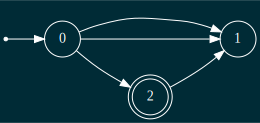

('green', 'blue', 'yellow') 0.0
('blue', 'green', 'yellow') 0.0
('blue', 'yellow') 0.0
('green', 'yellow') 1.0
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'energy': 16.906673380413174,
 'grad': array([ 0.32102235, -0.3109904 ,  0.38190486, -0.01224803,  0.3460407 ,
       -0.02267905,  0.        ]),
 'surprisal': 1.6906673380413173}


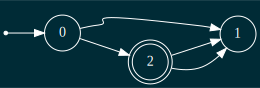

('green', 'blue', 'yellow') 0.9938628006978258
('blue', 'green', 'yellow') 0.9938628006978258
('blue', 'yellow') 0.9938628006978258
('green', 'yellow') 1.0
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.318346722000658,
 'grad': array([ 0.16478443, -0.15963492,  0.        , -0.0101956 ,  0.23522097,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


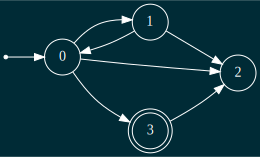

('green', 'blue', 'yellow') 0.0013744377500112496
('blue', 'green', 'yellow') 0.9999915127134306
('blue', 'yellow') 0.0013744377500112496
('green', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.096095648546182,
 'grad': array([ 0.08698911, -0.0842707 ,  0.        , -0.01579924,  0.38372874,
       -0.02729704, -0.84620827]),
 'surprisal': 2.1872952097231972}


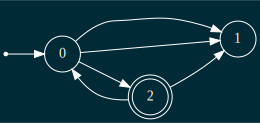

('green', 'blue', 'yellow') 0.0013744272180472345
('blue', 'green', 'yellow') 0.9999838500349083
('blue', 'yellow') 0.0013744272180472345
('green', 'yellow') 1.0
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 7.913017280509139,
 'grad': array([ 0.18442877, -0.17866537,  0.23939327, -0.00766115,  0.17222287,
       -0.0128037 , -0.39691469]),
 'surprisal': 0.7353401492573717}


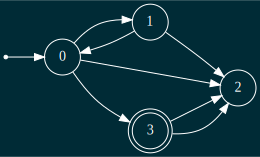

('green', 'blue', 'yellow') 0.00011390277581449864
('blue', 'green', 'yellow') 0.9999986616054826
('blue', 'yellow') 0.00011390277581449864
('green', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.        , -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


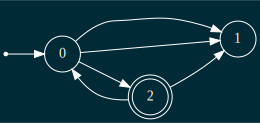

('green', 'blue', 'yellow') 0.0001139027117227457
('blue', 'green', 'yellow') 0.9999980989179914
('blue', 'yellow') 0.0001139027117227457
('green', 'yellow') 0.9999999999999999
{'conjecture': +: {('yellow', 'green')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 7.913017280509139,
 'grad': array([ 0.18442877, -0.17866537,  0.        , -0.00766115,  0.17222287,
       -0.0128037 ,  0.        ]),
 'surprisal': 0.7353401492573717}


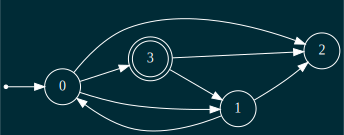

('green', 'blue', 'yellow') 5.9413245298495514e-05
('blue', 'green', 'yellow') 0.9999990083690722
('blue', 'yellow') 5.9413245298495514e-05
('green', 'yellow') 1.0
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.318346722000658,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


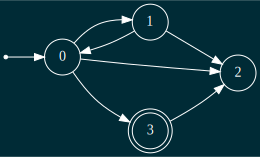

('green', 'blue', 'yellow') 5.9413245298495514e-05
('blue', 'green', 'yellow') 0.9999990083690722
('blue', 'yellow') 5.9413245298495514e-05
('green', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.375836336351515,
 'grad': array([ 0.0958404 , -0.09284538,  0.50271793, -0.01580353,  0.        ,
       -0.02729807, -0.84624018]),
 'surprisal': 2.197037122824335}


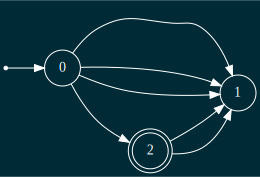

('green', 'blue', 'yellow') 5.941323042068067e-05
('blue', 'green', 'yellow') 0.9999987579568953
('blue', 'yellow') 5.941323042068067e-05
('green', 'yellow') 0.9999997495875749
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443, -0.15963492,  0.        , -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


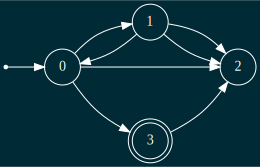

('green', 'blue', 'yellow') 5.7293335207958e-05
('blue', 'green', 'yellow') 0.9999988022736445
('blue', 'yellow') 5.7293335207958e-05
('green', 'yellow') 0.9999997585224215
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 21.99390405169145,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


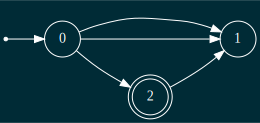

('green', 'blue', 'yellow') 5.7293335207958e-05
('blue', 'green', 'yellow') 0.9999988022736445
('blue', 'yellow') 5.7293335207958e-05
('green', 'yellow') 0.9999997585224215
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443,  0.        ,  0.        , -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


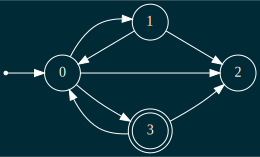

('green', 'blue', 'yellow') 5.531950622108247e-05
('blue', 'green', 'yellow') 0.9999988435368559
('blue', 'yellow') 5.531950622108247e-05
('green', 'yellow') 0.9999997668416342
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.        , -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


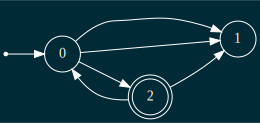

('green', 'blue', 'yellow') 5.531950622108247e-05
('blue', 'green', 'yellow') 0.9999988435368559
('blue', 'yellow') 5.531950622108247e-05
('green', 'yellow') 0.9999997668416342
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.318346722000658,
 'grad': array([ 0.16478443,  0.        ,  0.        , -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


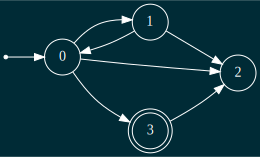

('green', 'blue', 'yellow') 5.531950622108247e-05
('blue', 'green', 'yellow') 0.9999988435368559
('blue', 'yellow') 5.531950622108247e-05
('green', 'yellow') 0.9999997668416342
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


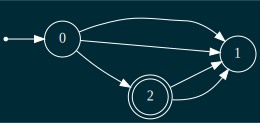

('green', 'blue', 'yellow') 5.5319491103224896e-05
('blue', 'green', 'yellow') 0.9999985702545885
('blue', 'yellow') 5.5319491103224896e-05
('green', 'yellow') 0.9999997668416979
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


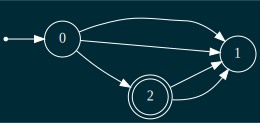

('green', 'blue', 'yellow') 5.5319491103224896e-05
('blue', 'green', 'yellow') 0.9999985702545885
('blue', 'yellow') 5.5319491103224896e-05
('green', 'yellow') 0.9999997668416979
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.318346722000658,
 'grad': array([ 0.16478443,  0.        ,  0.        , -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


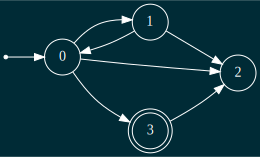

('green', 'blue', 'yellow') 5.5319491103224896e-05
('blue', 'green', 'yellow') 0.9999985702545885
('blue', 'yellow') 5.5319491103224896e-05
('green', 'yellow') 0.9999997668416979
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.19351477955756,
 'grad': array([ 0.0958404 , -0.09284538,  0.50271793, -0.01580353,  0.        ,
       -0.02729807, -0.84624018]),
 'surprisal': 2.197037122824335}


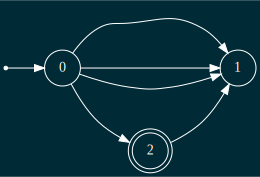

('green', 'blue', 'yellow') 5.531947562539089e-05
('blue', 'green', 'yellow') 0.9999982904651042
('blue', 'yellow') 5.531947562539089e-05
('green', 'yellow') 0.9999994870518789
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443,  0.        ,  0.        , -0.0101956 ,  0.        ,
       -0.01722764,  0.        ]),
 'surprisal': 0.9912881613892495}


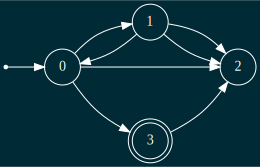

('green', 'blue', 'yellow') 5.531947562539089e-05
('blue', 'green', 'yellow') 0.9999982904651042
('blue', 'yellow') 5.531947562539089e-05
('green', 'yellow') 0.9999994870518789
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


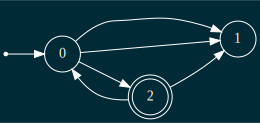

('green', 'blue', 'yellow') 5.531947562539089e-05
('blue', 'green', 'yellow') 0.9999982904651042
('blue', 'yellow') 5.531947562539089e-05
('green', 'yellow') 0.9999994870518789
prob = 0.445energy = 7.91size = 0.56


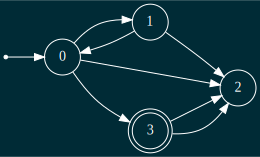

prob = 0.445energy = 7.91size = 0.56


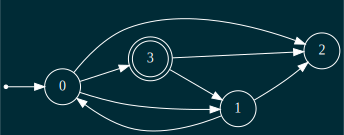

prob = 0.0402energy = 10.3size = 0.405


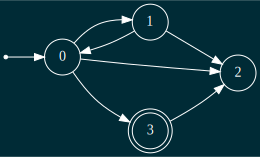

prob = 0.0345energy = 10.5size = 0.56


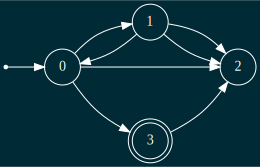

prob = 0.0345energy = 10.5size = 0.56


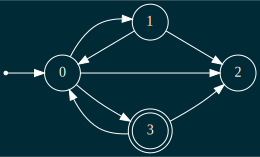

prob = 5.53e-05energy = 16.9size = 0.0


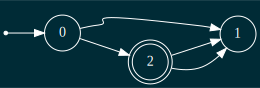

prob = 3.42e-07energy = 22.0size = 0.0


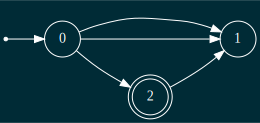

prob = 3.08e-07energy = 22.1size = 0.223


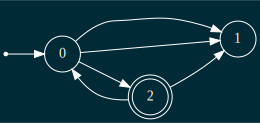

prob = 2.8e-07energy = 22.2size = 0.223


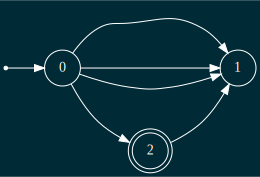

prob = 2.73e-07energy = 22.2size = 0.223


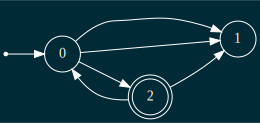

prob = 2.73e-07energy = 22.2size = 0.223


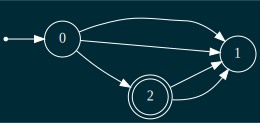

prob = 2.33e-07energy = 22.4size = 0.405


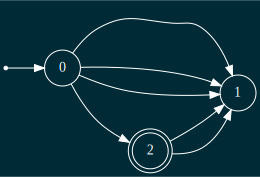

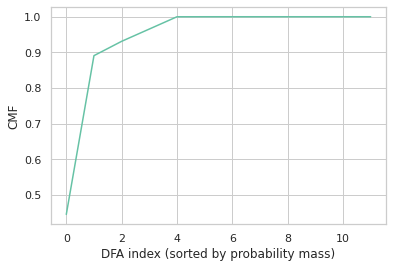

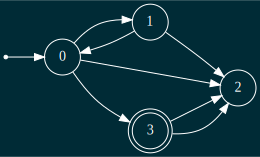

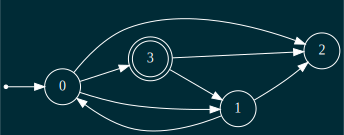

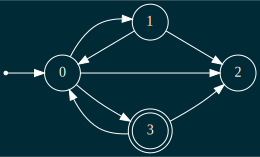

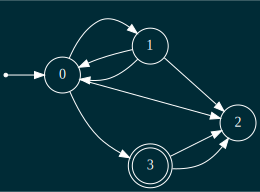

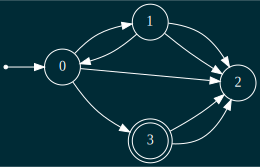

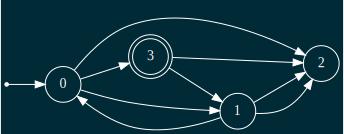

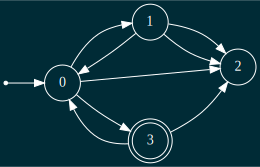

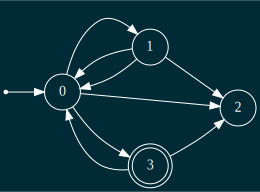

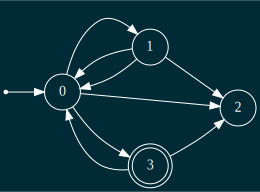

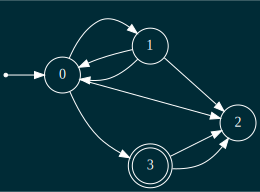

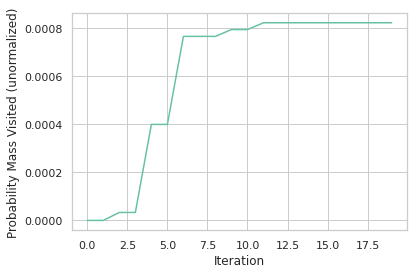

In [92]:
n_iters = 20

dfa_search = diss(
    demos=demos,
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lift_path,
    n_iters=n_iters,
    reset_period=5,
    surprise_weight=10,  # Rescale surprise to make comparable to size.
    sgs_greed=2,
    synth_timeout=3
)

df = analyze(dfa_search, n_iters)

<AxesSubplot:>

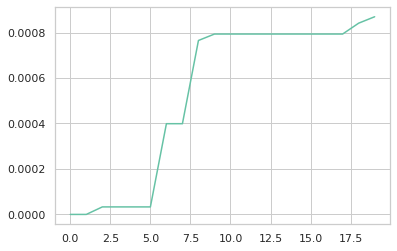

In [14]:
df['probability mass explored'].plot()

<AxesSubplot:>

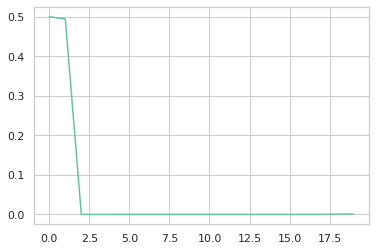

In [15]:
df['brier score'].plot()

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: set()
--------------
-: set(),
 'energy': 17.142066611086605,
 'grad': array([ 0.26168225, -0.25350468,  0.40478271, -0.01290501,  0.35267903,
       -0.02352295, -0.72921135]),
 'surprisal': 1.7142066611086604}


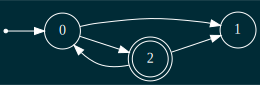

('green', 'blue', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
('green', 'yellow') 1.0
{'conjecture': +: {('yellow', 'green', 'green')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'yellow')},
 'energy': 22.096095648546182,
 'grad': array([ 0.        , -0.0842707 ,  0.5028574 , -0.01579924,  0.38372874,
       -0.02729704, -0.84620827]),
 'surprisal': 2.1872952097231972}


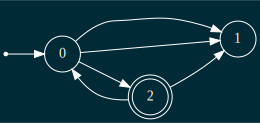

('green', 'blue', 'yellow') 0.9929944962924363
('blue', 'green', 'yellow') 0.9929944962924363
('blue', 'yellow') 0.9929944962924363
('green', 'yellow') 1.0
{'conjecture': +: set()
--------------
-: {('yellow', 'green', 'yellow')},
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.84624784]),
 'surprisal': 2.199390405169145}


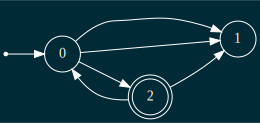

('green', 'blue', 'yellow') 0.9868685959129859
('blue', 'green', 'yellow') 0.9868685959129859
('blue', 'yellow') 0.9868685959129859
('green', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.663346769981338,
 'grad': array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.84624012]),
 'surprisal': 2.1970199589421395}


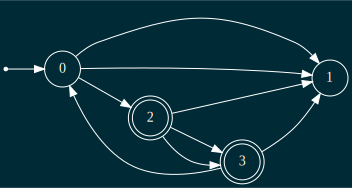

('green', 'blue', 'yellow') 0.9829875761708818
('blue', 'green', 'yellow') 0.9829875761708818
('blue', 'yellow') 0.9829875761708818
('green', 'yellow') 1.0
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.663346769981338,
 'grad': array([ 0.        , -0.09283035,  0.50271818,  0.        ,  0.        ,
        0.        , -0.84624012]),
 'surprisal': 2.1970199589421395}


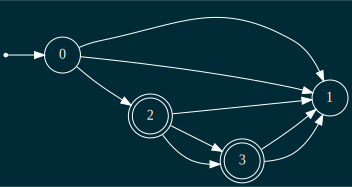

('green', 'blue', 'yellow') 0.9791369623234671
('blue', 'green', 'yellow') 0.9791369623234671
('blue', 'yellow') 0.9791369623234671
('green', 'yellow') 1.0000000000000002
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('yellow', 'green', 'green'), ('blue', 'green', 'yellow')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 10.1999029973179,
 'grad': array([ 0.16749646, -0.1622622 ,  0.        ,  0.        ,  0.        ,
        0.        , -0.50966063]),
 'surprisal': 0.938897278110157}


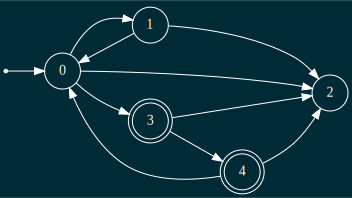

('green', 'blue', 'yellow') 0.0009652244519003327
('blue', 'green', 'yellow') 0.9999794334042312
('blue', 'yellow') 0.0009652244519003327
('green', 'yellow') 1.0
{'conjecture': +: {('yellow', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.467043932866197,
 'grad': array([ 0.09013139, -0.08731478,  0.        ,  0.        ,  0.        ,
       -0.02729741, -0.8462196 ]),
 'surprisal': 2.190742814493077}


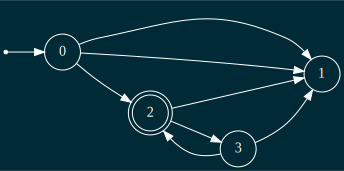

('green', 'blue', 'yellow') 0.0009652199161794355
('blue', 'green', 'yellow') 0.999974734364952
('blue', 'yellow') 0.0009652199161794355
('green', 'yellow') 1.0000000000000002
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.375836336351515,
 'grad': array([ 0.0958404 , -0.09284538,  0.50271793,  0.        ,  0.38362883,
       -0.02729807, -0.84624018]),
 'surprisal': 2.197037122824335}


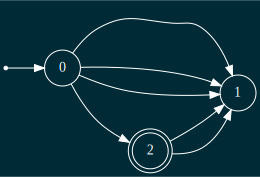

('green', 'blue', 'yellow') 0.0009652149473624362
('blue', 'green', 'yellow') 0.9999695866350142
('blue', 'yellow') 0.0009652149473624362
('green', 'yellow') 0.9999948521399985
{'conjecture': +: {('yellow', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.52981537735682,
 'grad': array([ 0.09582488, -0.09283035,  0.50271818,  0.        ,  0.        ,
       -0.02729807, -0.84624012]),
 'surprisal': 2.1970199589421395}


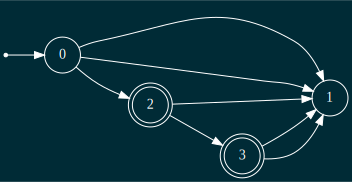

('green', 'blue', 'yellow') 0.000965210687686094
('blue', 'green', 'yellow') 0.9999651735798676
('blue', 'yellow') 0.000965210687686094
('green', 'yellow') 0.999994852162717
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'yellow')},
 'energy': 21.99390405169145,
 'grad': array([ 0.09796564, -0.09490421,  0.        ,  0.        ,  0.        ,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


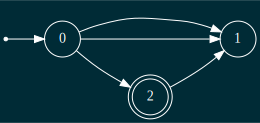

('green', 'blue', 'yellow') 0.000965203407964989
('blue', 'green', 'yellow') 0.9999576317367538
('blue', 'yellow') 0.000965203407964989
('green', 'yellow') 0.9999948522015425
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow', 'green', 'green'),
 ('yellow', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.23522097,
       -0.01722764, -0.53405681]),
 'surprisal': 0.9912881613892495}


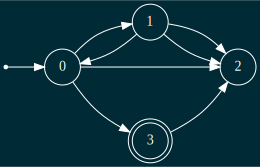

('green', 'blue', 'yellow') 0.0005482134276431514
('blue', 'green', 'yellow') 0.9999759357969253
('blue', 'yellow') 0.0005482134276431514
('green', 'yellow') 0.999997076168387
{'conjecture': +: {('green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.19351477955756,
 'grad': array([ 0.        , -0.09284538,  0.50271793, -0.01580353,  0.38362883,
       -0.02729807, -0.84624018]),
 'surprisal': 2.197037122824335}


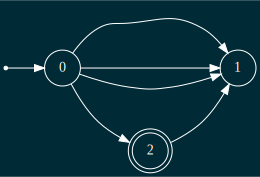

('green', 'blue', 'yellow') 0.0005482115041893996
('blue', 'green', 'yellow') 0.9999724272957313
('blue', 'yellow') 0.0005482115041893996
('green', 'yellow') 0.99999356759302
{'conjecture': +: {('yellow', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.52981537735682,
 'grad': array([ 0.09582488, -0.09283035,  0.50271818, -0.01580352,  0.38362901,
       -0.02729807, -0.84624012]),
 'surprisal': 2.1970199589421395}


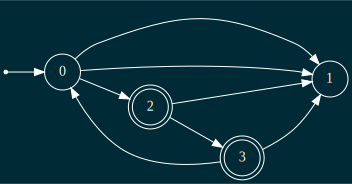

('green', 'blue', 'yellow') 0.0005482101300662939
('blue', 'green', 'yellow') 0.9999699208083503
('blue', 'yellow') 0.0005482101300662939
('green', 'yellow') 0.9999935676091432
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


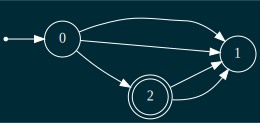

('green', 'blue', 'yellow') 0.0005482082513708427
('blue', 'green', 'yellow') 0.9999664939491251
('blue', 'yellow') 0.0005482082513708427
('green', 'yellow') 0.9999935676311866
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow', 'green', 'green'),
 ('yellow', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443, -0.15963492,  0.32110956, -0.0101956 ,  0.        ,
        0.        , -0.53405681]),
 'surprisal': 0.9912881613892495}


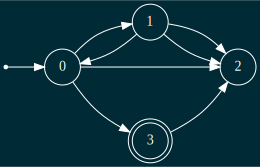

('green', 'blue', 'yellow') 0.00038282195837987566
('blue', 'green', 'yellow') 0.9999766022273808
('blue', 'yellow') 0.00038282195837987566
('green', 'yellow') 0.9999955081813892
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564, -0.09490421,  0.50268444, -0.01580456,  0.38360484,
       -0.02729832, -0.84624784]),
 'surprisal': 2.199390405169145}


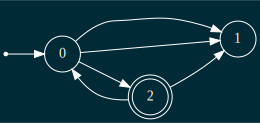

('green', 'blue', 'yellow') 0.00038282195837987566
('blue', 'green', 'yellow') 0.9999766022273808
('blue', 'yellow') 0.00038282195837987566
('green', 'yellow') 0.9999955081813892
{'conjecture': +: {('yellow', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'green')}
--------------
-: {('yellow', 'green', 'yellow'), ('blue', 'yellow')},
 'energy': 22.663346769981338,
 'grad': array([ 0.        , -0.09283035,  0.50271818, -0.01580352,  0.        ,
        0.        , -0.84624012]),
 'surprisal': 2.1970199589421395}


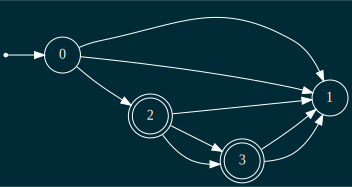

('green', 'blue', 'yellow') 0.00038282195837987566
('blue', 'green', 'yellow') 0.9999766022273808
('blue', 'yellow') 0.00038282195837987566
('green', 'yellow') 0.9999955081813892
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('yellow', 'green', 'yellow'), ('yellow', 'green', 'green')}
--------------
-: {('blue', 'yellow')},
 'energy': 22.21704760300566,
 'grad': array([ 0.09796564,  0.        ,  0.50268444, -0.01580456,  0.38360484,
        0.        , -0.84624784]),
 'surprisal': 2.199390405169145}


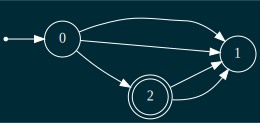

('green', 'blue', 'yellow') 0.00038282195837987566
('blue', 'green', 'yellow') 0.9999766022273808
('blue', 'yellow') 0.00038282195837987566
('green', 'yellow') 0.9999955081813892
{'conjecture': +: set()
--------------
-: {('yellow', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow', 'green', 'green'),
 ('yellow', 'green', 'yellow')}
--------------
-: {('blue', 'yellow')},
 'energy': 10.472497401827917,
 'grad': array([ 0.16478443,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.53405681]),
 'surprisal': 0.9912881613892495}


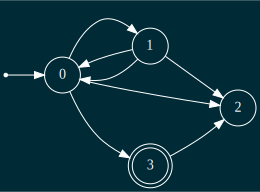

('green', 'blue', 'yellow') 0.0002940971985393794
('blue', 'green', 'yellow') 0.9999820250139032
('blue', 'yellow') 0.0002940971985393794
('green', 'yellow') 0.9999965492280656
{'conjecture': +: set()
--------------
-: {('green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow'),
 ('yellow', 'green', 'green'),
 ('yellow', 'green', 'yellow')}
--------------
-: {('yellow', 'yellow'), ('blue', 'yellow')},
 'energy': 10.318346722000658,
 'grad': array([0.16478443, 0.        , 0.        , 0.        , 0.23522097,
       0.        , 0.        ]),
 'surprisal': 0.9912881613892495}


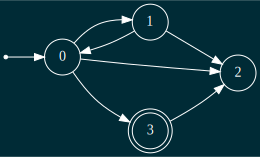

('green', 'blue', 'yellow') 0.00023150103477617034
('blue', 'green', 'yellow') 0.9999858508414833
('blue', 'yellow') 0.00023150103477617034
('green', 'yellow') 0.9999972836964188
prob = 0.24energy = 10.2size = 0.811


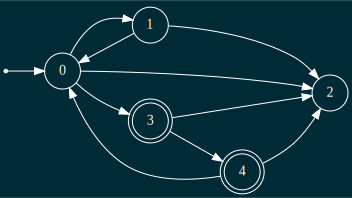

prob = 0.213energy = 10.3size = 0.405


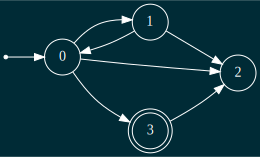

prob = 0.182energy = 10.5size = 0.56


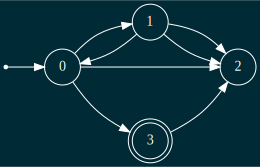

prob = 0.182energy = 10.5size = 0.56


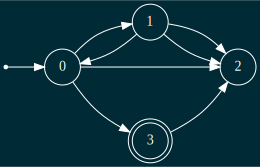

prob = 0.182energy = 10.5size = 0.56


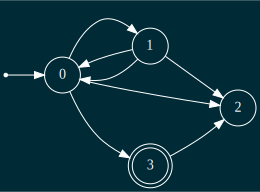

prob = 0.000232energy = 17.1size = 0.0


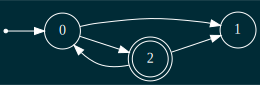

prob = 1.81e-06energy = 22.0size = 0.0


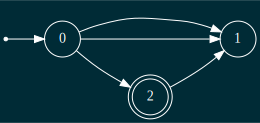

prob = 1.63e-06energy = 22.1size = 0.223


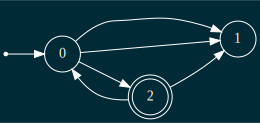

prob = 1.48e-06energy = 22.2size = 0.223


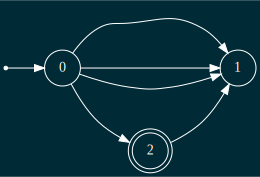

prob = 1.45e-06energy = 22.2size = 0.223


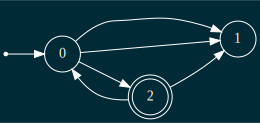

prob = 1.45e-06energy = 22.2size = 0.223


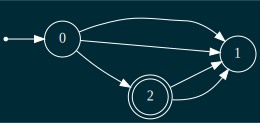

prob = 1.23e-06energy = 22.4size = 0.405


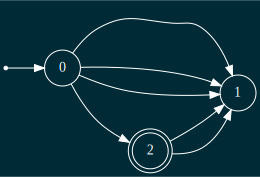

prob = 1.13e-06energy = 22.5size = 0.56


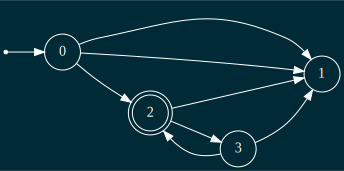

prob = 1.06e-06energy = 22.5size = 0.56


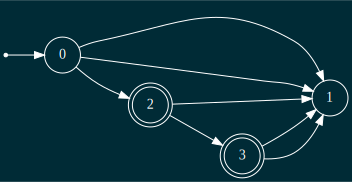

prob = 1.06e-06energy = 22.5size = 0.56


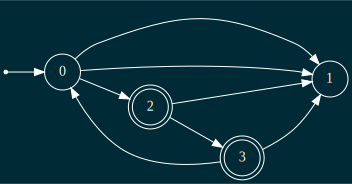

prob = 9.26e-07energy = 22.7size = 0.693


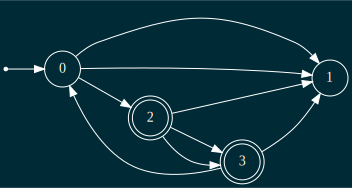

prob = 9.26e-07energy = 22.7size = 0.693


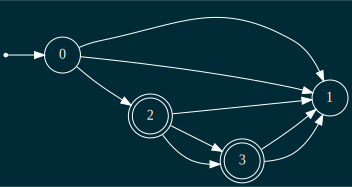

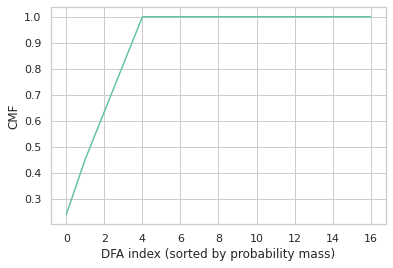

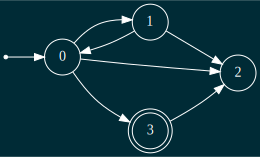

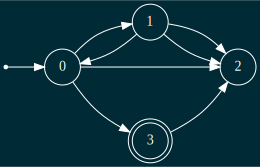

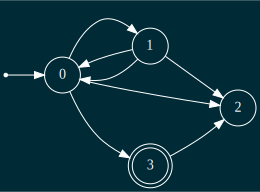

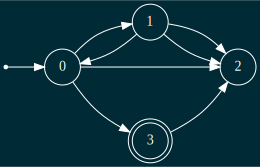

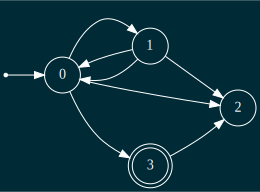

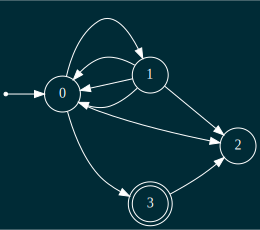

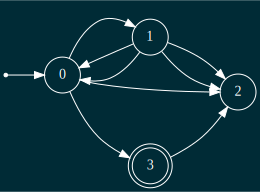

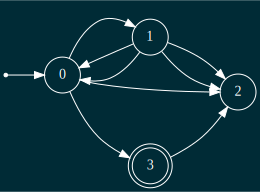

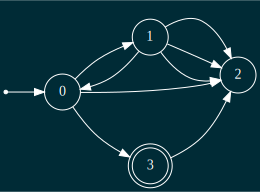

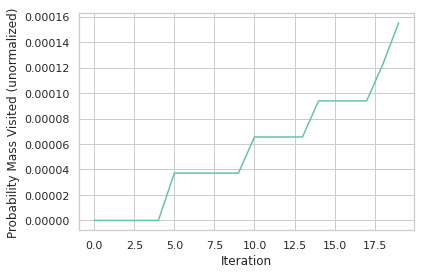

In [17]:
dfa_search = diss(
    demos=demos,
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lift_path,
    n_iters=n_iters,
    reset_period=4,
    surprise_weight=10,  # Rescale surprise to make comparable to size.
    sgs_greed=0,
)

df2 = analyze(dfa_search, n_iters)

<AxesSubplot:>

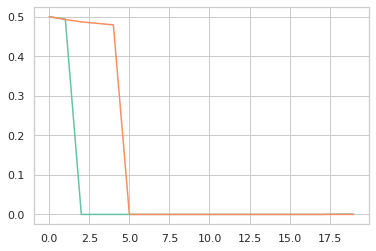

In [18]:
df['brier score'].plot()
df2['brier score'].plot()

<AxesSubplot:>

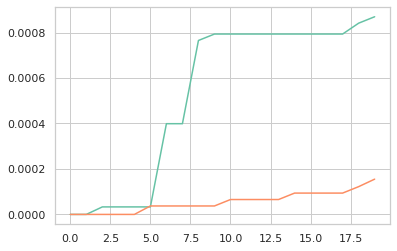

In [19]:
df['probability mass explored'].plot()
df2['probability mass explored'].plot()

# Enumeration baseline

In [31]:
from diss.experiment.concept_class import enumerative_search

In [32]:
from diss.experiment import concept_class

In [33]:
import importlib
importlib.reload(concept_class)


<module 'diss.experiment.concept_class' from '/home/mvc/work/code/DISS/diss/experiment/concept_class.py'>

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

{'energy': 16.854384538634825}


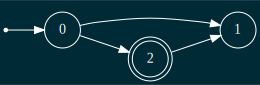

('green', 'blue', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
('green', 'yellow') 1.0
{'energy': 17.142066611086605}


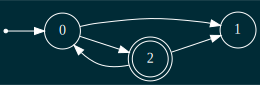

('green', 'blue', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
('green', 'yellow') 1.0
{'energy': 21.99390405169145}


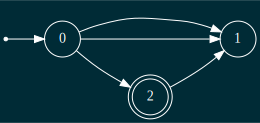

('green', 'blue', 'yellow') 0.9966623174696508
('blue', 'green', 'yellow') 0.9966623174696508
('blue', 'yellow') 0.9966623174696508
('green', 'yellow') 1.0
{'energy': 17.142066611086605}


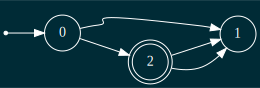

('green', 'blue', 'yellow') 0.9976612804577478
('blue', 'green', 'yellow') 0.9976612804577478
('blue', 'yellow') 0.9976612804577478
('green', 'yellow') 1.0000000000000002
{'energy': 16.906673380413174}


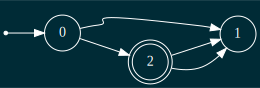

('green', 'blue', 'yellow') 0.9983037196039846
('blue', 'green', 'yellow') 0.9983037196039846
('blue', 'yellow') 0.9983037196039846
('green', 'yellow') 1.0
{'energy': 17.00763599857311}


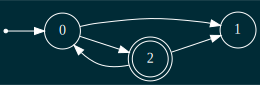

('green', 'blue', 'yellow') 0.9986411460544602
('blue', 'green', 'yellow') 0.9986411460544602
('blue', 'yellow') 0.9986411460544602
('green', 'yellow') 1.0
{'energy': 31.458058391835078}


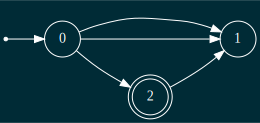

('green', 'blue', 'yellow') 0.9986410407729309
('blue', 'green', 'yellow') 0.9986410407729309
('blue', 'yellow') 0.9986411461977169
('green', 'yellow') 0.999999894575214
{'energy': 22.21704760300566}


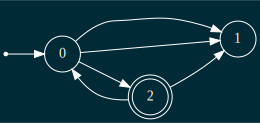

('green', 'blue', 'yellow') 0.9975566138947043
('blue', 'green', 'yellow') 0.9975566138947043
('blue', 'yellow') 0.9975567192050092
('green', 'yellow') 0.9999998946896952
{'energy': 22.21704760300566}


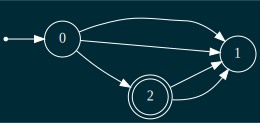

('green', 'blue', 'yellow') 0.9964745396256534
('blue', 'green', 'yellow') 0.9964745396256534
('blue', 'yellow') 0.9964746448217255
('green', 'yellow') 0.9999998948039279
{'energy': 17.129816931727383}


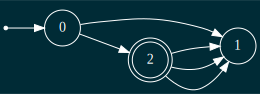

('green', 'blue', 'yellow') 0.9970012955104426
('blue', 'green', 'yellow') 0.9970012955104426
('blue', 'yellow') 0.9970013849886669
('green', 'yellow') 0.9999999105217758
{'energy': 17.129816931727383}


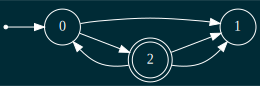

('green', 'blue', 'yellow') 0.9973911032441876
('blue', 'green', 'yellow') 0.9973911032441876
('blue', 'yellow') 0.9973911810909544
('green', 'yellow') 0.9999999221532332
{'energy': 21.99691792767934}


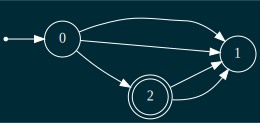

('green', 'blue', 'yellow') 0.9963943379068888
('blue', 'green', 'yellow') 0.9963943379068888
('blue', 'yellow') 0.9963944156758576
('green', 'yellow') 0.9999999222310312
{'energy': 22.19351477955756}


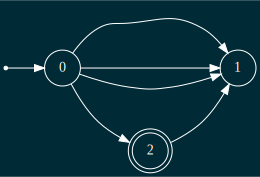

('green', 'blue', 'yellow') 0.9955769629118806
('blue', 'green', 'yellow') 0.9955769629118806
('blue', 'yellow') 0.995577040617053
('green', 'yellow') 0.9991795894568016
{'energy': 31.681201943149286}


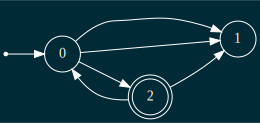

('green', 'blue', 'yellow') 0.9955769010227008
('blue', 'green', 'yellow') 0.9955769010227008
('blue', 'yellow') 0.9955770408920026
('green', 'yellow') 0.9991795273436678
{'energy': 17.23077954988732}


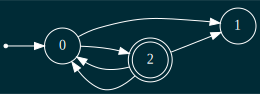

('green', 'blue', 'yellow') 0.9960412425149019
('blue', 'green', 'yellow') 0.9960412425149019
('blue', 'yellow') 0.9960413677005799
('green', 'yellow') 0.9992656614092871
{'energy': 22.096095648546182}


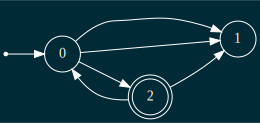

('green', 'blue', 'yellow') 0.9952357585999865
('blue', 'green', 'yellow') 0.9952357585999865
('blue', 'yellow') 0.9952358836844288
('green', 'yellow') 0.9992662552581133
{'energy': 34.74270930993856}


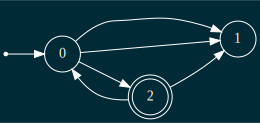

('green', 'blue', 'yellow') 0.9952357560096808
('blue', 'green', 'yellow') 0.9952357560096808
('blue', 'yellow') 0.9952358836968284
('green', 'yellow') 0.9992662526573176
{'energy': 31.681201943149286}


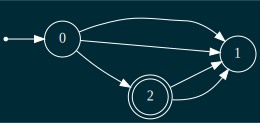

('green', 'blue', 'yellow') 0.9952357006814576
('blue', 'green', 'yellow') 0.9952357006814576
('blue', 'yellow') 0.9952358839616803
('green', 'yellow') 0.9992661971050267
{'energy': 36.67699949868342}


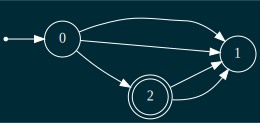

('green', 'blue', 'yellow') 0.9952357003070891
('blue', 'green', 'yellow') 0.9952357003070891
('blue', 'yellow') 0.9952358839634723
('green', 'yellow') 0.9992661967291421
{'energy': 17.23077954988732}


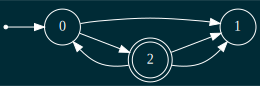

('green', 'blue', 'yellow') 0.9956880112348752
('blue', 'green', 'yellow') 0.9956880112348752
('blue', 'yellow') 0.9956881774553719
('green', 'yellow') 0.9993358622119303
prob = 0.138energy = 16.9size = -0.288


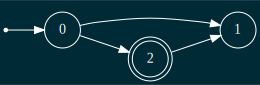

prob = 0.131energy = 16.9size = 0.0


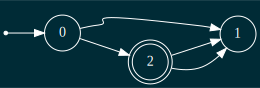

prob = 0.119energy = 17.0size = 0.0


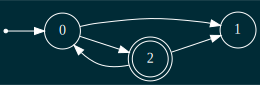

prob = 0.105energy = 17.1size = 0.223


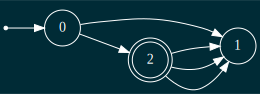

prob = 0.105energy = 17.1size = 0.223


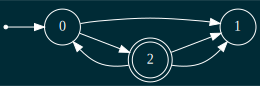

prob = 0.104energy = 17.1size = 0.0


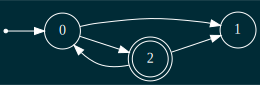

prob = 0.104energy = 17.1size = 0.0


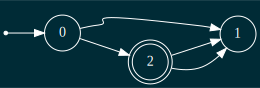

prob = 0.0949energy = 17.2size = 0.223


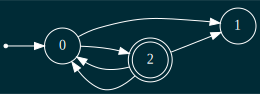

prob = 0.0949energy = 17.2size = 0.223


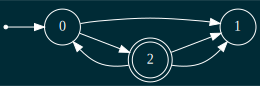

prob = 0.000811energy = 22.0size = 0.0


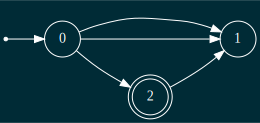

prob = 0.000808energy = 22.0size = 0.223


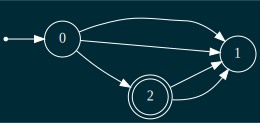

prob = 0.000732energy = 22.1size = 0.223


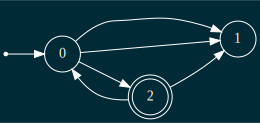

prob = 0.000664energy = 22.2size = 0.223


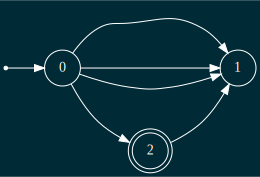

prob = 0.000649energy = 22.2size = 0.223


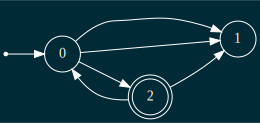

prob = 0.000649energy = 22.2size = 0.223


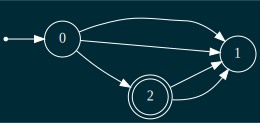

prob = 6.29e-08energy = 31.5size = 0.0


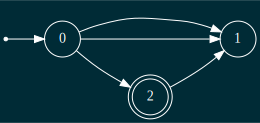

prob = 5.03e-08energy = 31.7size = 0.223


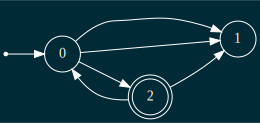

prob = 5.03e-08energy = 31.7size = 0.223


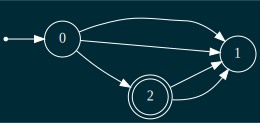

prob = 2.36e-09energy = 34.7size = 0.223


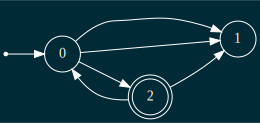

prob = 3.4e-10energy = 36.7size = 0.223


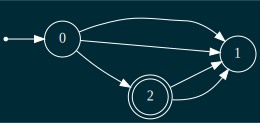

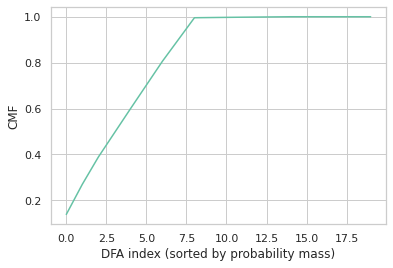

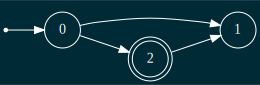

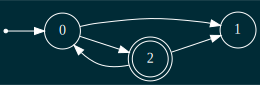

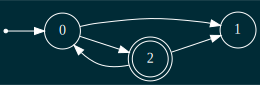

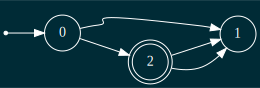

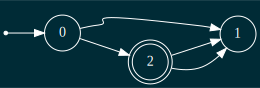

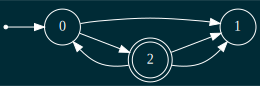

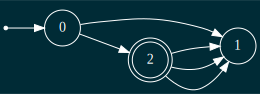

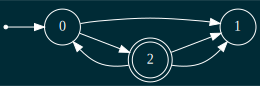

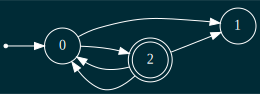

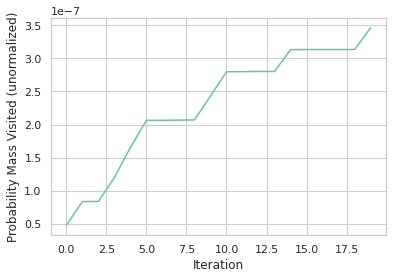

In [34]:
dfa_search = concept_class.enumerative_search(
    demos=demos,
    identifer=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    n_iters=n_iters,
    surprise_weight=10,  # Rescale surprise to make comparable to size.
)

df3 = analyze(dfa_search, n_iters)

<AxesSubplot:>

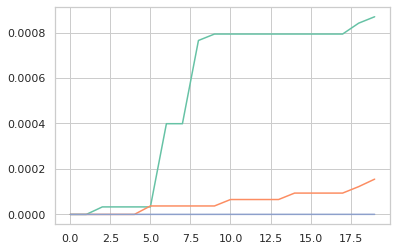

In [35]:
df['probability mass explored'].plot()
df2['probability mass explored'].plot()
df3['probability mass explored'].plot()

# Circuit + BDD based MaxEnt Policy (CAV '20)

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨

Everything after this point of the notebook is currently under development!

🚨 🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧  🚧 🚨 

# 1. Create Dynamical System

Here we create a BitVector sequential circuit, `DYN`, using `py-aiger`, the models a gridworld (line 4).

Afterwords, lines 6-8 describe introducing a slip probability of `1/32` (modeled by a biased coin with bias `31/32`). 

**Note that states are 1-hot encoded**

In [36]:
import aiger as A
import aiger_bv as BV
import aiger_gridworld as GW
import aiger_ptltl as LTL
from bidict import bidict
from aiger_bdd import to_bdd

In [37]:
STATE = BV.uatom(16, 'state')
X = STATE[:8]
Y = STATE[8:]
s0 = (3, 5)
#                            
DYN = GW.gridworld(8, start=(s0[0], 9 - s0[1]), compressed_inputs=True)
SLIP = BV.atom(1, 'c', signed=False).repeat(2) & BV.atom(2, 'a', signed=False)
SLIP = SLIP.with_output('a').aigbv
DYN <<= SLIP

def encode_state(x, y):
    x, y = x - 1, (9 - y) + 7
    return {'state': (1 << x) | (1 << y)}

# 2. Create Sensor / Feature overlay

Next, we define the mapping from concrete states to sensor values / atomic predicates.
We use simple coordinate wise bitvector masks to encode the color overlays.

In [38]:
def mask_test(xmask, ymask):
    return ((X & xmask) !=0) & ((Y & ymask) != 0)


APS = {       #            x-axis       y-axis
    'yellow': mask_test(0b0000_0001, 0b1000_0001),
    'blue':   mask_test(0b0000_1010, 0b0011_1100),
    'green':  mask_test(0b0010_0000, 0b1000_0000),
    'red':    mask_test(0b1000_0000, 0b0011_0010) \
            | mask_test(0b0011_1111, 0b0000_0010),
}

def create_sensor(aps):
    sensor = BV.aig2aigbv(A.empty())
    for name, ap in APS.items():
        sensor |= ap.with_output(name).aigbv
    aps = reduce(lambda x, y: x.concat(y), APS.values())
    sensor |= (aps == 0).with_output('white').aigbv
    return sensor

SENSOR = create_sensor(APS)

In [39]:
SENSOR.outputs

{'blue', 'green', 'red', 'white', 'yellow'}

## Visualizing Overlay

This can all seem pretty abstract, so let's visualize the way the sensor sees the board.

In [40]:
from IPython.display import HTML as html_print


def tile(color='black'):
    color = COLOR_ALIAS.get(color, color)
    s = '&nbsp;'*4
    return f"<text style='border: solid 1px;background-color:{color}'>{s}</text>"


def ap_at_state(x, y, in_ascii=False):
    """Use sensor to create colored tile."""
    state = encode_state(x, y)
    obs = SENSOR(state)[0]   # <----------   
    for k in COLOR_ALIAS.keys():
        if k == 'brown':
            continue
        if obs[k][0]:
            return tile(k)
    raise NotImplementedError

def print_map():
    """Scan the board row by row and print colored tiles."""
    order = range(1, 9)
    buffer = ''
    for y in order:
        chars = (ap_at_state(x, y, in_ascii=True) for x in order)
        buffer += '&nbsp;'.join(chars) + '<br>'
    display(html_print(buffer))
    
DYN_SENSE = DYN >> SENSOR

def encode_trace(trc):
    actions, states = trc
    actions = [{'a': a} for a in actions]
    states = [encode_state(*s) for s in states]

    # Fill in coin flips to mark slipping. Could use SAT solver more generally.
    for s, a, s2 in zip([encode_state(*s0)] + states, actions, states):
        s, s2 = GW.GridState(s['state'], 8), GW.GridState(s2['state'], 8)
        action = a['a']
        print(s.x, s.y)
        print(s2.x, s2.y)

        if action == GW.WEST:
            a['c'] = 1
        elif action == GW.EAST:
            a['c'] = int((s2.x > s.x) or s.x == 8)
        else:
            a['c'] = int(s.x == s2.x)
    actions[-1]['c'] = 1  # Last action needs some arbitrary assignment to slipping.
    
    return actions, states


def lift_path(path):
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    print(ignore_white(aps))
    return ignore_white(aps)


def print_trc(trc, idx=0):
    obs = lift_path(trc)
    actions = [x['a'] for x in trc]
    obs = map(tile, obs)
    display(
        html_print(f'trc {idx}:&nbsp;&nbsp;&nbsp;' + ''.join(''.join(x) for x in zip(actions, obs)) + '\n')
    )
        
print_map()

TRC4 = [
    {'a': '↑', 'c': 0},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '↑', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '→', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},
    {'a': '←', 'c': 1},

]

print(len(TRC4))

print_trc(TRC4, 4)

14
('blue', 'blue', 'blue', 'green', 'yellow')


# 4. Define Specification Circuits / Concept Class



In [41]:
import aiger_dfa

In [42]:
from dfa import DFA, dfa2dict, dict2dfa
from functools import reduce

def concept2monitor(concept):
    # Add noop on white:
    def transition_with_noop(s, c):
        if c == 'white':
            return s
        return concept.dfa._transition(s, c)
    
    dfa = DFA(
        start=concept.dfa.start,
        outputs=concept.dfa.outputs,
        inputs=COLOR_ALIAS,
        label=concept.dfa._label,
        transition=transition_with_noop,
    )
    dfa = attr.evolve(concept.dfa, transition=transition_with_noop, inputs=frozenset(COLOR_ALIAS))
    circ, relabels, _ = aiger_dfa.dfa2aig(dfa)
    # Wrap circ i/o to interface with sensor.
    atoms = [BV.uatom(1, c) for c in COLOR_ALIAS]

    # Convert input.
    def get_idx(atom):
        c = fn.first(atom.inputs)
        return relabels['inputs'][c]['action'].index(True)

    atoms = sorted(atoms, key=get_idx)
    action = reduce(lambda x, y: x.concat(y), atoms).with_output('action')
    
    # Convert output.
    output = BV.uatom(2, 'output')
    for key, val in relabels['outputs'].items():
        if val is True:
            sat = output[key['output'].index(True)].with_output('SAT')
    
    monitor = action.aigbv >> circ >> sat.aigbv
    monitor = attr.evolve(monitor, aig=monitor.aig.lazy_aig)  # HACK: force lazy evaluation.
    return DYN >> SENSOR >> monitor, relabels

# Creating BDD game-graph

In [43]:
H = 15  # SAT output only depends on latch....
causal_order = []
for t in range(H):
    causal_order.append(f'a##time_{t}[0]')
    causal_order.append(f'a##time_{t}[1]')
    causal_order.append(f'c##time_{t}[0]')
causal_order = {x: i for i, x in enumerate(causal_order)}

In [44]:
from dd.cudd import BDD

In [45]:
manager = BDD()
manager.declare(*causal_order)

In [46]:
import networkx as nx

In [47]:
def to_nx(bexpr):
    # DFS to translate edge-compelemented BDD to networkx graph.
    dag = nx.DiGraph()

    stack, visited = [(bexpr, False, int(bexpr))], set()
    while stack:
        bexpr, parity, ref = stack.pop()

        if ref in visited:
            continue

        visited.add(ref)
        if bexpr in (bexpr.bdd.true, bexpr.bdd.false):
            label = (bexpr == bexpr.bdd.true) ^ parity
            dag.add_node(ref, label=label, level=len(bexpr.bdd.vars))
            continue

        dag.add_node(ref, label=bexpr.var, level=bexpr.level)

        parity = bexpr.negated ^ parity
        for lbl, bexpr2 in [(0, bexpr.low), (1, bexpr.high)]:
            ref2 = int(bexpr2 if parity else ~bexpr2)
            dag.add_edge(ref, ref2, label=lbl)
            stack.append((bexpr2, parity, ref2))
            
    #TODO: Everything above this line should be upstreamed into aiger-bdd.
            
    for src, data in dag.nodes(data=True):
        label = data['label']
        if isinstance(label, bool):
            data['kind'] = label
        elif label.startswith('a'):
            data['kind'] = 'ego'
        else:
            data['kind'] = 'env'

    for src, tgt, data in dag.edges(data=True):
        entropy = dag.nodes[tgt]['level'] - dag.nodes[src]['level'] - 1
        entropy /= np.log2(np.e)  # Convert from base 2.
        data['entropy'] = entropy
    
        if dag.nodes[src]['kind'] == 'env':
            data['prob'] = 31/32 if data['label'] else 1/32
    return dag

# Create Tabular Policy from BDD

1. Create policy on BDD Game graph.
2. Lift bit level policy into policy over ego and env actions (at bitvectors)

In [48]:
from diss import DemoPrefixTree as PrefixTree

In [49]:
from diss.planners.tabular import TabularPolicy

In [50]:
import dd.cudd

In [51]:
def to_demo(trc):
    demo = [(None, 'ego')]
    for circ_input in trc:
        demo.extend([
            (circ_input['a'], 'env'),
            (circ_input['c'], 'ego'),
        ])
    return demo

In [52]:
tree = PrefixTree.from_demos([to_demo(TRC4)])

In [53]:
#               bdd-id    lvl   prev action  
# Node = tuple[  int  ,   int,  int | str]   # Lifted policy state.

def get_lvl(dag, node):
    label = dag.nodes[node]['label']
    if isinstance(label, bool):
        return len(causal_order)
    return causal_order[label]

def get_debt(dag, node1, node2):
    lvl1 = get_lvl(dag, node1)
    lvl2 = get_lvl(dag, node2)
    return lvl2 - lvl1 - 1

def walk(dag, curr, bits):
    for bit in bits:
        yield curr
        node, debt = curr
        if debt > 0:  # Don't care consumes bits.
            curr = (node, debt - 1)
            continue
        # Use bit for BDD transition.
        if dag.out_degree(node) == 0:
            import pdb; pdb.set_trace()
        for kid in dag.neighbors(node):
            if bit == dag.edges[node, kid]['label']:
                break
        curr = (kid, get_debt(dag, node, kid))
    yield curr


@attr.frozen
class LiftedPolicy:
    policy: TabularPolicy

    def psat(self, node = None): return self.policy.psat(node[0])
    def lsat(self, node = None): return self.policy.lsat(node[0])
        
    @property
    def root(self):
        return (self.policy.root, 0, None)

    @staticmethod
    def from_psat(unrolled, psat, xtol=0.5):
        return LiftedPolicy(TabularPolicy.from_psat(unrolled, psat, xtol=xtol))

    def prob(self, node, move, log = False):
        dag = self.policy.dag
        node1, debt1, _ = node 
        node2, debt2, action = move
        assert (node1 != node2) or (debt1 > debt2 >= 0)

        if isinstance(action, int):
            prob = 31 / 32 if action else 1/32
            return np.log(prob) if log else prob

        action = GW.dynamics.ACTIONS_C[action]
        bits = [action & 1, (action >> 1) & 1]
        curr = (node1, debt1)
        edges = fn.pairwise(walk(dag, (node1, debt1), bits))
        
        logp = 0
        for start, end in edges:
            if start[0] == end[0]:  # Don't care consumes bits.
                logp -= np.log(2)
            else:
                logp += self.policy.prob(start[0], end[0], log=True)

        assert end == (node2, debt2)
        return logp if log else np.exp(logp)

    def transition(self, pstate, action):
        dag = self.policy.dag
        if isinstance(action, str):  # action correspond to previous action.
            bits = GW.dynamics.ACTIONS_C[action]
            bits = [bits & 1, (bits >> 1) & 1]
        else:
            bits = [action]
        node, debt = fn.last(walk(dag, pstate[:2], bits))  # QDD state.
        return (node, debt, action)

    def end_of_episode(self, pstate):
        node, debt, _ = pstate
        dag = self.policy.dag
        return (debt == 0) and (dag.out_degree(node) == 0)

In [54]:
def dont_count(aps):
    for curr, prev in fn.with_prev(aps):
        if curr == prev:
            continue
        yield curr

In [55]:
def lift_path(path):
    assert path[0] is None
    path = path[1:]
    path = [{'a': a, 'c': c} for a, c in fn.chunks(2, path)]
    aps = fn.pluck(0, DYN_SENSE.simulate(path))
    aps = [fn.first(k for k, v in ap.items() if v == 1) for ap in aps]
    aps = list(dont_count(aps))
    aps = ignore_white(aps)
    return aps

In [56]:
import random

@attr.frozen
class CompressedMC:
    """Compressed Markov Chain operating with actions."""
    tree: PrefixTree
    policy: LiftedPolicy
    tree2policy: dict[int, tuple[int, int]]

    @property
    def edge_probs(self):
        edge_probs = {}
        for tree_edge in self.tree.tree.edges:
            dag_edge = [self.tree2policy[s] for s in tree_edge]
            edge_probs[tree_edge] = self.policy.prob(*dag_edge)
        return edge_probs
    
    def sample(self, pivot, win, attempts=20):
        # Sample until you give a path that respects subset properties.
        for i in range(attempts):
            result = self._sample(pivot, win)
            if result is None:
                return result
            word = lift_path(result[0])
            print('HEREEE', word)
            if (not win) and ('red' in word) and ('yellow' not in word):
                continue
            return result

    def _sample(self, pivot, win):
        policy = self.policy
        state = self.tree2policy[pivot]

        if policy.psat(state) == float(not win):
            return None  # Impossible to realize is_sat label.

        sample_prob: float = 1
        path = list(self.tree.prefix(pivot))
        if policy.end_of_episode(state):
             moves = []
        else:
            prev_ego = isinstance(state[-1], str)

            # Make sure to deviate from prefix tree at pivot.
            actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
            actions -= {self.tree2policy[s][-1] for s in self.tree.tree.neighbors(pivot)}

            tmp = {policy.transition(state, a) for a in actions}

            moves = list(m for m in tmp if policy.psat(m) != float(not win))

        if not moves:
            return None  # Couldn't deviate
        
        # Sample suffix to path conditioned on win.
        while moves:
            # Apply bayes rule to get Pr(s' | is_sat, s).
            priors = np.array([policy.prob(state, m) for m in moves])
            likelihoods = np.array([policy.psat(m) for m in moves])
            normalizer = policy.psat(state)

            if not win:
                likelihoods = 1 - likelihoods
                normalizer = 1 - normalizer

            probs =  priors * likelihoods / normalizer
            prob, state = random.choices(list(zip(probs, moves)), probs)[0]
            sample_prob *= prob

            # Note: win/lose are strings so the below still works...
            action = state[-1]
            path.append(action)

            if policy.end_of_episode(state):
                moves = []
            else:
                prev_ego = isinstance(action, str)
                actions = {0, 1} if prev_ego else set(GW.dynamics.ACTIONS_C)
                moves = [policy.transition(state, a) for a in actions]

        return path, sample_prob
 
    @staticmethod
    def construct(concept, tree, psat):
        # 1. Compile concept: DFA -> AIG -> BDD -> Annotated DAG.
        monitor, _ = concept2monitor(concept)
        unrolled = monitor.aigbv.cone('SAT').unroll(H, only_last_outputs=True)
        manager = BDD()
        manager.declare(*causal_order)
        bexpr, *_ = to_bdd(unrolled, manager=manager, renamer=lambda _, x: x, levels=causal_order)
        dag = to_nx(bexpr)
        
        # 2. Fit (lifted) MaxEntPolicy.
        policy = LiftedPolicy.from_psat(dag, psat=psat)
        
        # 3. Need to associcate each tree stree with a policy state.
        stack = [(tree.root, policy.root)]
        tree2policy = {}
        while stack:
            tstate, pstate = stack.pop()
            tree2policy[tstate] = pstate

            # Compute local mapping from dynamics transition to next pstate.
            #move = {s[0]: s for s in policy.dag.neighbors(pstate)}
            for tstate2 in tree.tree.neighbors(tstate):
                action = tree.state(tstate2)  # tree states are next actions.
                pstate2 = policy.transition(pstate, action)
                stack.append((tstate2, pstate2))
        return CompressedMC(tree, policy, tree2policy)

# DISS + BDD

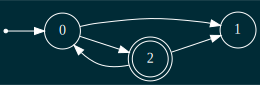

In [57]:
@fn.memoize(key_func=lambda c, t, psat: c.dfa)
def to_chain(c, t, psat):
    return CompressedMC.construct(concept=c, tree=t, psat=psat)

identifer = PartialDFAIdentifier(
    partial = PARTIAL_DFA,
    base_examples = BASE_EXAMPLES,
)
view_dfa(identifer(LabeledExamples()))

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: set(),
 'energy': 9.06817358988092,
 'grad': array([ 0.10820633, -0.10482488,  0.74746391, -0.02346392,  0.20446392,
       -0.02912017,  0.0729561 , -0.03049004,  0.04110656, -0.03082181,
        0.03339299, -0.03090216,  0.03152487, -0.03092162,  0.03107243,
       -0.03092633,  0.03096285, -0.03092747,  0.03093632, -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.13634717976184}


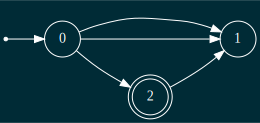

('blue', 'yellow') 0.0
('green', 'blue', 'yellow') 0.0
('blue', 'green', 'yellow') 0.0
('green', 'yellow') 1.0
HEREEE ('blue', 'blue', 'red', 'blue', 'red')
HEREEE ('blue', 'red', 'yellow', 'red')
{'conjecture': +: {('blue', 'red', 'yellow', 'red')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'energy': 8.440213191118406,
 'grad': array([ 0.61171466, -0.59259857,  0.54688579, -0.01768756,  0.24257843,
       -0.0247154 ,  0.20660299, -0.03039939,  0.0347138 , -0.03053421,
        0.036826  , -0.03073083,  0.04408239, -0.03114807,  0.03296571,
       -0.03120487,  0.03157169, -0.03121633,  0.00881355, -0.03051624,
        0.00835958, -0.02982385,  0.00868984, -0.02916341,  0.01054078,
       -0.02858145,  0.01335487, -0.02810562,  0.        ]),
 'surprisal': 16.880426382236813}


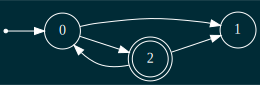

('blue', 'yellow') 0.6520268450828021
('green', 'blue', 'yellow') 0.6520268450828021
('blue', 'green', 'yellow') 0.6520268450828021
('green', 'yellow') 1.0
HEREEE ('blue',)
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'red', 'yellow', 'red'), ('blue', 'green', 'yellow')}
--------------
-: set(),
 'energy': 8.440213191118406,
 'grad': array([ 0.61171466, -0.59259857,  0.54688579, -0.01768756,  0.24257843,
       -0.0247154 ,  0.20660299, -0.03039939,  0.0347138 , -0.03053421,
        0.036826  , -0.03073083,  0.04408239, -0.03114807,  0.03296571,
       -0.03120487,  0.03157169, -0.03121633,  0.00881355, -0.03051624,
        0.00835958, -0.02982385,  0.00868984, -0.02916341,  0.01054078,
       -0.02858145,  0.01335487, -0.02810562,  0.        ]),
 'surprisal': 16.880426382236813}


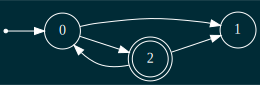

('blue', 'yellow') 0.6520268450828021
('green', 'blue', 'yellow') 0.6520268450828021
('blue', 'green', 'yellow') 0.6520268450828021
('green', 'yellow') 1.0
HEREEE ('blue', 'blue')
{'conjecture': +: {('blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'red', 'yellow', 'red'), ('blue', 'green', 'yellow'), ('blue',)}
--------------
-: set(),
 'energy': 8.241524891247302,
 'grad': array([ 0.56981946, -0.5520126 ,  0.50240325, -0.01625657,  0.24707448,
       -0.02346963,  0.2463862 , -0.03043577,  0.03290619, -0.03051297,
        0.03678681, -0.03070903,  0.04549741, -0.03117116,  0.03237591,
       -0.03120881,  0.03145343, -0.03121646,  0.00881248, -0.03051633,
        0.00835915, -0.02982392,  0.00868958, -0.02916347,  0.01054057,
       -0.02858151,  0.01335467, -0.02810567,  0.        ]),
 'surprisal': 17.058413927398163}


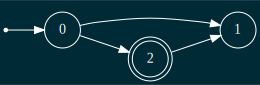

('blue', 'yellow') 0.8061801741342636
('green', 'blue', 'yellow') 0.8061801741342636
('blue', 'green', 'yellow') 0.8061801741342636
('green', 'yellow') 1.0
HEREEE ('blue', 'blue', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'blue', 'yellow')},
 'data': +: set()
--------------
-: set(),
 'energy': 8.440213191118406,
 'grad': array([ 0.61171466, -0.59259857,  0.54688579, -0.01768756,  0.24257843,
       -0.0247154 ,  0.20660299, -0.03039939,  0.0347138 , -0.03053421,
        0.036826  , -0.03073083,  0.04408239, -0.03114807,  0.03296571,
       -0.03120487,  0.03157169, -0.03121633,  0.00881355, -0.03051624,
        0.00835958, -0.02982385,  0.00868984, -0.02916341,  0.01054078,
       -0.02858145,  0.01335487, -0.02810562,  0.        ]),
 'surprisal': 16.880426382236813}


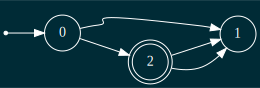

('blue', 'yellow') 0.8578175294659272
('green', 'blue', 'yellow') 0.8578175294659272
('blue', 'green', 'yellow') 0.8578175294659272
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'blue', 'yellow')},
 'energy': 9.320809638806598,
 'grad': array([ 0.15928746, -0.15430972,  0.7462667 , -0.02347639,  0.20417397,
       -0.02912319,  0.07288588, -0.03049077,  0.04108955, -0.03082198,
        0.03338888, -0.0309022 ,  0.03152387, -0.03092163,  0.03107219,
       -0.03092633,  0.0309628 , -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.195332174984777}


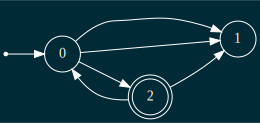

('blue', 'yellow') 0.7725021527895457
('green', 'blue', 'yellow') 0.7725021527895457
('blue', 'green', 'yellow') 0.7725021527895457
('green', 'yellow') 1.0
HEREEE ('blue', 'blue', 'green', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'yellow')},
 'energy': 6.118843638445231,
 'grad': array([ 0.09927219, -0.09616993,  0.87005753, -0.02728624,  0.13426838,
       -0.03062943,  0.04344359, -0.03102988,  0.03193774, -0.03105825,
        0.03061032, -0.03104425,  0.01749553, -0.03062085,  0.00775943,
       -0.02990643,  0.00553127, -0.02914471,  0.00778146, -0.02847711,
        0.01016421, -0.02790483,  0.01274612, -0.02743112,  0.0155449 ,
       -0.02705968,  0.0186076 , -0.02679555, -0.830662  ]),
 'surprisal': 11.118455701019617}


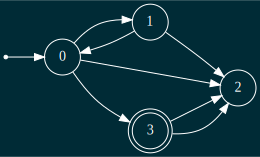

('blue', 'yellow') 0.2242570848614709
('green', 'blue', 'yellow') 0.2242570848614709
('blue', 'green', 'yellow') 0.9339574603857762
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


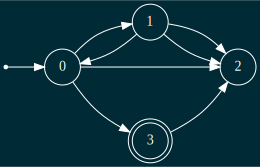

('blue', 'yellow') 0.219341673833516
('green', 'blue', 'yellow') 0.219341673833516
('blue', 'green', 'yellow') 0.9354050232475446
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


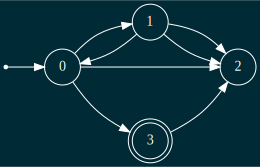

('blue', 'yellow') 0.219341673833516
('green', 'blue', 'yellow') 0.219341673833516
('blue', 'green', 'yellow') 0.9354050232475446
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'yellow'),
 ('blue', 'green', 'yellow')},
 'energy': 9.322035976113078,
 'grad': array([ 0.16134692, -0.15630483,  0.        , -0.02347689,  0.20416228,
       -0.02912331,  0.07288305, -0.0304908 ,  0.04108886, -0.03082199,
        0.03338871, -0.0309022 ,  0.03152383, -0.03092163,  0.03107218,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19778484959774}


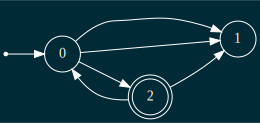

('blue', 'yellow') 0.21332491181723018
('green', 'blue', 'yellow') 0.21332491181723018
('blue', 'green', 'yellow') 0.9097459256608696
('green', 'yellow') 1.0
HEREEE ('blue', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 10.576496851065247,
 'grad': array([ 0.40305357, -0.39045815,  0.91517564, -0.02899285,  0.07591634,
       -0.0304592 ,  0.04182349, -0.03081434,  0.03356663, -0.03090035,
        0.03156692, -0.03092118,  0.03108261, -0.03092622,  0.03096532,
       -0.03092744,  0.03093691, -0.03092774,  0.03093003, -0.03092781,
        0.03092837, -0.03092783,  0.03092796, -0.03092783,  0.03092787,
       -0.03092783,  0.03092784, -0.03092783, -0.95876288]),
 'surprisal': 19.766699341010604}


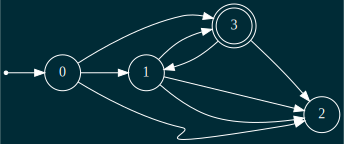

('blue', 'yellow') 0.2194321785578152
('green', 'blue', 'yellow') 0.2194321785578152
('blue', 'green', 'yellow') 0.9104466033799098
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'yellow'),
 ('blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


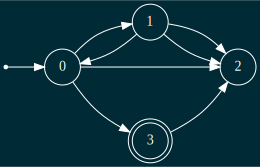

('blue', 'yellow') 0.2194321785578152
('green', 'blue', 'yellow') 0.2194321785578152
('blue', 'green', 'yellow') 0.9104466033799098
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 10.216692943141599,
 'grad': array([ 0.42297688, -0.40975886,  0.86936868, -0.02758083,  0.10874559,
       -0.03011723,  0.04977432, -0.03073152,  0.03549222, -0.03088029,
        0.03203327, -0.03091632,  0.03119556, -0.03092505,  0.03099267,
       -0.03092716,  0.03094354, -0.03092767,  0.03093164, -0.0309278 ,
        0.03092876, -0.03092783,  0.03092806, -0.03092783,  0.03092789,
       -0.03092783,  0.03092785, -0.03092783, -0.95876288]),
 'surprisal': 19.314154310412352}


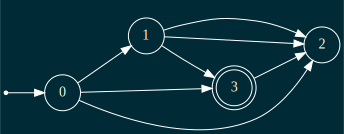

('blue', 'yellow') 0.2280206920574832
('green', 'blue', 'yellow') 0.2280206920574832
('blue', 'green', 'yellow') 0.9114319508855138
('green', 'yellow') 0.9999999999999999
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 10.576390560364363,
 'grad': array([ 0.40325433, -0.39065264,  0.91513016, -0.02899162,  0.07594482,
       -0.03045891,  0.04183039, -0.03081427,  0.0335683 , -0.03090033,
        0.03156732, -0.03092117,  0.03108271, -0.03092622,  0.03096534,
       -0.03092744,  0.03093692, -0.03092774,  0.03093004, -0.03092781,
        0.03092837, -0.03092783,  0.03092796, -0.03092783,  0.03092787,
       -0.03092783,  0.03092784, -0.03092783, -0.95876288]),
 'surprisal': 19.766486759608835}


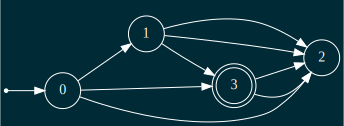

('blue', 'yellow') 0.23390338542731226
('green', 'blue', 'yellow') 0.23390338542731226
('blue', 'green', 'yellow') 0.912106863632454
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


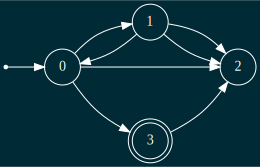

('blue', 'yellow') 0.23390338542731226
('green', 'blue', 'yellow') 0.23390338542731226
('blue', 'green', 'yellow') 0.912106863632454
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


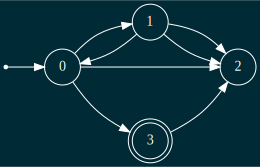

('blue', 'yellow') 0.23390338542731226
('green', 'blue', 'yellow') 0.23390338542731226
('blue', 'green', 'yellow') 0.912106863632454
('green', 'yellow') 1.0
HEREEE ('blue', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'), ('blue', 'blue', 'yellow')},
 'energy': 10.216692943141599,
 'grad': array([ 0.42297688, -0.40975886,  0.86936868, -0.02758083,  0.10874559,
       -0.03011723,  0.04977432, -0.03073152,  0.03549222, -0.03088029,
        0.03203327, -0.03091632,  0.03119556, -0.03092505,  0.03099267,
       -0.03092716,  0.03094354, -0.03092767,  0.03093164, -0.0309278 ,
        0.03092876, -0.03092783,  0.03092806, -0.03092783,  0.03092789,
       -0.03092783,  0.03092785, -0.03092783, -0.95876288]),
 'surprisal': 19.314154310412352}


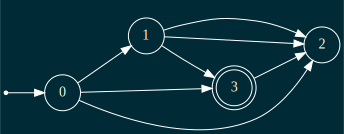

('blue', 'yellow') 0.23390338542731226
('green', 'blue', 'yellow') 0.23390338542731226
('blue', 'green', 'yellow') 0.912106863632454
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'yellow'),
 ('blue', 'yellow')},
 'energy': 9.574186525298868,
 'grad': array([ 0.14853265, -0.143891  ,  0.70524033, -0.02218381,  0.23422637,
       -0.02881014,  0.0801642 , -0.03041496,  0.04285227, -0.03080362,
        0.03381578, -0.03089775,  0.03162726, -0.03092055,  0.03109723,
       -0.03092607,  0.03096886, -0.03092741,  0.03093777, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 18.02914147472689}


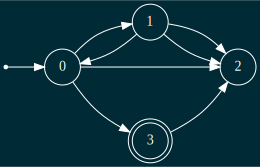

('blue', 'yellow') 0.23390338542731226
('green', 'blue', 'yellow') 0.23390338542731226
('blue', 'green', 'yellow') 0.912106863632454
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: set()
--------------
-: {('blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'yellow'),
 ('blue', 'green', 'yellow'),
 ('blue', 'yellow')},
 'energy': 9.322159122789799,
 'grad': array([ 0.16155345, -0.15650491,  0.        , -0.02347694,  0.2041611 ,
       -0.02912332,  0.07288277, -0.0304908 ,  0.0410888 , -0.03082199,
        0.03338869, -0.0309022 ,  0.03152382, -0.03092163,  0.03107218,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19803114295118}


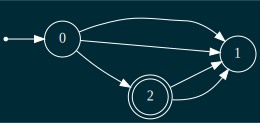

('blue', 'yellow') 0.2278183235868047
('green', 'blue', 'yellow') 0.2278183235868047
('blue', 'green', 'yellow') 0.8883781490599166
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'green', 'yellow')}
--------------
-: {('blue', 'blue', 'green', 'yellow'),
 ('blue', 'blue', 'yellow'),
 ('blue', 'yellow')},
 'energy': 9.687545381391772,
 'grad': array([ 0.11343635, -0.10989146,  0.70603098, -0.02217425,  0.23444878,
       -0.02880783,  0.08021807, -0.0304144 ,  0.04286531, -0.03080349,
        0.03381894, -0.03089772,  0.03162803, -0.03092054,  0.03109741,
       -0.03092607,  0.0309689 , -0.03092741,  0.03093778, -0.03092773,
        0.03093024, -0.03092781,  0.03092842, -0.03092783,  0.03092798,
       -0.03092783,  0.03092787, -0.03092783, -0.95876288]),
 'surprisal': 17.988796401663652}


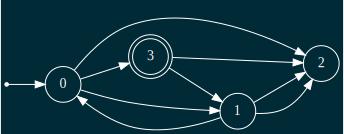

('blue', 'yellow') 0.2237785072133095
('green', 'blue', 'yellow') 0.2237785072133095
('blue', 'green', 'yellow') 0.8903574972263331
('green', 'yellow') 1.0
prob = 0.629energy = 6.12size = 0.56


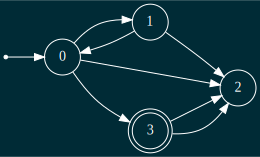

prob = 0.0753energy = 8.24size = -0.288


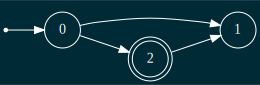

prob = 0.0617energy = 8.44size = 0.0


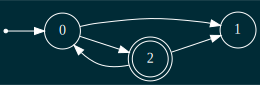

prob = 0.0617energy = 8.44size = 0.0


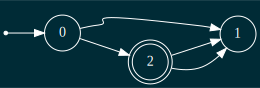

prob = 0.0329energy = 9.07size = 0.0


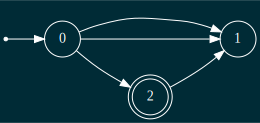

prob = 0.0256energy = 9.32size = 0.223


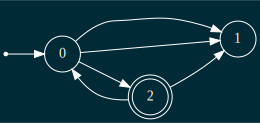

prob = 0.0256energy = 9.32size = 0.223


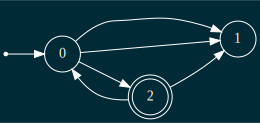

prob = 0.0256energy = 9.32size = 0.223


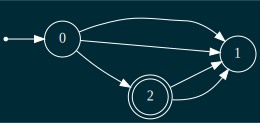

prob = 0.0199energy = 9.57size = 0.56


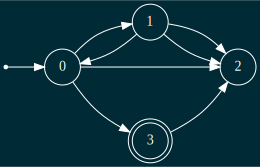

prob = 0.0177energy = 9.69size = 0.693


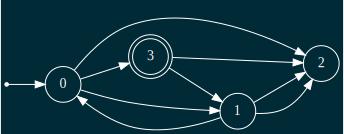

prob = 0.0104energy = 10.2size = 0.56


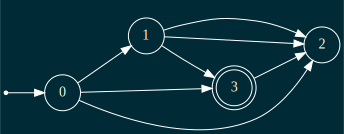

prob = 0.00729energy = 10.6size = 0.693


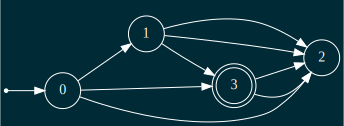

prob = 0.00729energy = 10.6size = 0.693


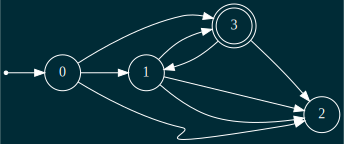

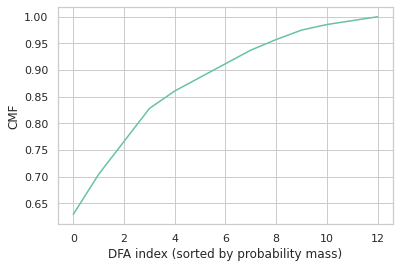

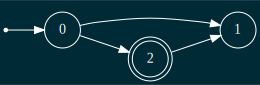

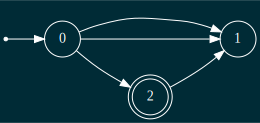

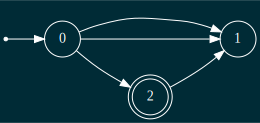

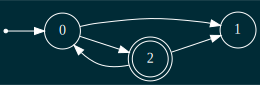

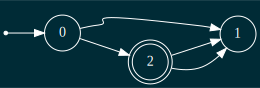

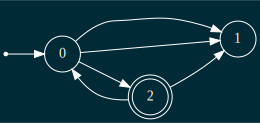

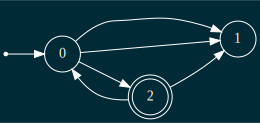

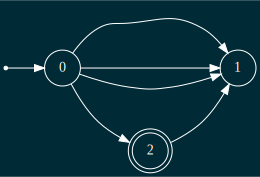

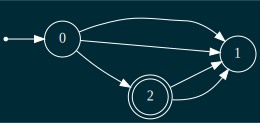

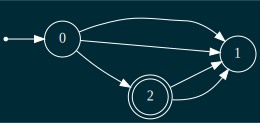

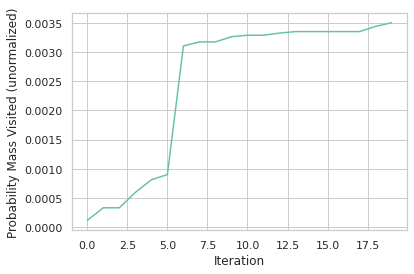

In [58]:
n_iters = 20

dfa_search = diss(
    demos=[to_demo(TRC4)],
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: lift_path(x),
    n_iters=n_iters,
    reset_period=4,
    surprise_weight=1/2,  # Rescale surprise to make comparable to size.
    sgs_greed=4,
)

df_greed4 = analyze(dfa_search, n_iters)

In [117]:
df_greed4['treatment'] = 'greed = 4'
df_greed4['iteration'] = df_greed4.index

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

HEREEE ('blue', 'green')
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: set()
--------------
-: set(),
 'energy': 8.079832190409848,
 'grad': array([ 0.62369593, -0.60420543,  0.56885218, -0.01838571,  0.24665541,
       -0.02551914,  0.1809796 , -0.03037728,  0.03671101, -0.03057521,
        0.03667843, -0.03076593,  0.04197926, -0.03111635,  0.03316446,
       -0.03118035,  0.03234416, -0.03121672,  0.00546196, -0.03041188,
        0.00653579, -0.02966576,  0.00823109, -0.02899592,  0.01073555,
       -0.02842529,  0.01379607, -0.02796812, -0.86701181]),
 'surprisal': 16.159664380819695}


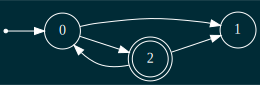

('green', 'blue', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
('green', 'yellow') 1.0
HEREEE ('blue', 'blue', 'red', 'blue')
HEREEE ('blue', 'blue', 'blue', 'red')
HEREEE ('blue', 'blue', 'blue', 'blue')
{'conjecture': +: {('blue', 'blue', 'blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'green')}
--------------
-: set(),
 'energy': 8.079754616584408,
 'grad': array([ 0.62381561, -0.60432137,  0.56898366, -0.01838993,  0.24666318,
       -0.02552347,  0.18083444, -0.03037694,  0.0367194 , -0.03057514,
        0.03668069, -0.03076594,  0.04197741, -0.0311163 ,  0.03316586,
       -0.03118035,  0.03234425, -0.03121672,  0.00546197, -0.03041188,
        0.00653579, -0.02966576,  0.00823109, -0.02899592,  0.01073555,
       -0.02842529,  0.01379607, -0.02796812, -0.86701181]),
 'surprisal': 16.159509233168816}


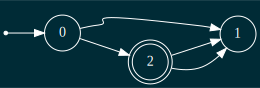

('green', 'blue', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9999999999999999
('green', 'yellow') 0.9999999999999999
HEREEE ('blue', 'blue', 'blue', 'blue', 'blue', 'blue')
{'conjecture': +: {('blue', 'blue', 'blue', 'blue', 'blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'green'), ('blue', 'blue', 'blue', 'blue')}
--------------
-: set(),
 'energy': 8.079754616584408,
 'grad': array([ 0.62381561, -0.60432137,  0.56898366, -0.01838993,  0.24666318,
       -0.02552347,  0.18083444, -0.03037694,  0.0367194 , -0.03057514,
        0.03668069, -0.03076594,  0.04197741, -0.0311163 ,  0.03316586,
       -0.03118035,  0.03234425, -0.03121672,  0.00546197, -0.03041188,
        0.00653579, -0.02966576,  0.00823109, -0.02899592,  0.01073555,
       -0.02842529,  0.01379607, -0.02796812, -0.86701181]),
 'surprisal': 16.159509233168816}


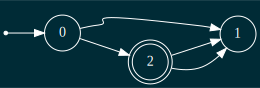

('green', 'blue', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9999999999999999
('green', 'yellow') 0.9999999999999999
HEREEE ('blue', 'yellow')
{'conjecture': +: {('blue', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: set(),
 'energy': 9.06817358988092,
 'grad': array([ 0.10820633, -0.10482488,  0.74746391, -0.02346392,  0.20446392,
       -0.02912017,  0.0729561 , -0.03049004,  0.04110656, -0.03082181,
        0.03339299, -0.03090216,  0.03152487, -0.03092162,  0.03107243,
       -0.03092633,  0.03096285, -0.03092747,  0.03093632, -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.13634717976184}


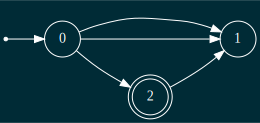

('green', 'blue', 'yellow') 0.8431066738625881
('blue', 'green', 'yellow') 0.8431066738625881
('blue', 'yellow') 0.8431066738625881
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: set()
--------------
-: {('blue', 'green', 'yellow')},
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: set(),
 'energy': 8.079832190409848,
 'grad': array([ 0.62369593, -0.60420543,  0.56885218, -0.01838571,  0.24665541,
       -0.02551914,  0.1809796 , -0.03037728,  0.03671101, -0.03057521,
        0.03667843, -0.03076593,  0.04197926, -0.03111635,  0.03316446,
       -0.03118035,  0.03234416, -0.03121672,  0.00546196, -0.03041188,
        0.00653579, -0.02966576,  0.00823109, -0.02899592,  0.01073555,
       -0.02842529,  0.01379607, -0.02796812, -0.86701181]),
 'surprisal': 16.159664380819695}


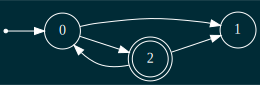

('green', 'blue', 'yellow') 0.8431066738625881
('blue', 'green', 'yellow') 0.8431066738625881
('blue', 'yellow') 0.8431066738625881
('green', 'yellow') 1.0
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 11.77248149062347,
 'grad': array([ 0.56982736, -0.55202025,  0.50240319, -0.01625657,  0.24707425,
       -0.02346962,  0.24638683, -0.03043579,  0.03290585, -0.03051298,
        0.03678658, -0.03070903,  0.04549846, -0.0311712 ,  0.032389  ,
       -0.03120925,  0.03178976, -0.03122739,  0.0239631 , -0.03100038,
        0.02924106, -0.03094541,  0.03051932, -0.03093209,  0.0308289 ,
       -0.03092887,  0.03090387, -0.03092808, -0.95877062]),
 'surprisal': 23.54496298124694}


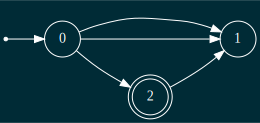

('green', 'blue', 'yellow') 0.8343470550254337
('blue', 'green', 'yellow') 0.8343470550254337
('blue', 'yellow') 0.8447367472301262
('green', 'yellow') 0.9896103077953073
HEREEE ('blue', 'green')
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.322035976113078,
 'grad': array([ 0.16134692, -0.15630483,  0.74621843, -0.02347689,  0.        ,
       -0.02912331,  0.07288305, -0.0304908 ,  0.04108886, -0.03082199,
        0.03338871, -0.0309022 ,  0.03152383, -0.03092163,  0.03107218,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19778484959774}


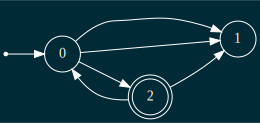

('green', 'blue', 'yellow') 0.7446515379722362
('blue', 'green', 'yellow') 0.7446515379722362
('blue', 'yellow') 0.7539242983094158
('green', 'yellow') 0.9907272396628204
HEREEE ('blue', 'blue', 'blue', 'red', 'blue', 'red')
HEREEE ('blue', 'red', 'blue', 'red')
HEREEE ('blue', 'blue', 'blue')
{'conjecture': +: {('blue', 'blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.322035976113078,
 'grad': array([ 0.16134692, -0.15630483,  0.74621843, -0.02347689,  0.20416228,
       -0.02912331,  0.07288305, -0.0304908 ,  0.04108886, -0.03082199,
        0.03338871, -0.0309022 ,  0.03152383, -0.03092163,  0.03107218,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surpri

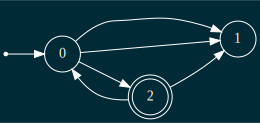

('green', 'blue', 'yellow') 0.7446515379722362
('blue', 'green', 'yellow') 0.7446515379722362
('blue', 'yellow') 0.7539242983094158
('green', 'yellow') 0.9907272396628204
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.06817358988092,
 'grad': array([ 0.10820633, -0.10482488,  0.74746391, -0.02346392,  0.20446392,
       -0.02912017,  0.0729561 , -0.03049004,  0.04110656, -0.03082181,
        0.03339299, -0.03090216,  0.03152487, -0.03092162,  0.03107243,
       -0.03092633,  0.03096285, -0.03092747,  0.03093632, -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.13634717976184}


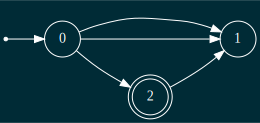

('green', 'blue', 'yellow') 0.7446515379722362
('blue', 'green', 'yellow') 0.7446515379722362
('blue', 'yellow') 0.7539242983094158
('green', 'yellow') 0.9907272396628204
HEREEE ('blue',)
{'conjecture': +: {('blue',)}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.322159122789799,
 'grad': array([ 0.16155345, -0.15650491,  0.74621359, -0.02347694,  0.        ,
       -0.02912332,  0.07288277, -0.0304908 ,  0.0410888 , -0.03082199,
        0.03338869, -0.0309022 ,  0.03152382, -0.03092163,  0.03107218,
       -0.03092633,  0.        , -0.03092747,  0.0309363 , -0.03092775,
        0.        , -0.03092781,  0.03092833, -0.03092783,  0.        ,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19803114295118}


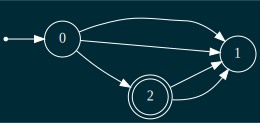

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'green')
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.322159122789799,
 'grad': array([ 0.16155345, -0.15650491,  0.74621359, -0.02347694,  0.2041611 ,
       -0.02912332,  0.07288277, -0.0304908 ,  0.        , -0.03082199,
        0.03338869, -0.0309022 ,  0.03152382, -0.03092163,  0.        ,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19803114295118}


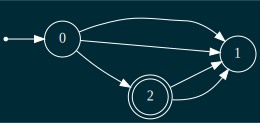

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'blue', 'blue', 'blue')
{'conjecture': +: {('blue', 'blue', 'blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.06817358988092,
 'grad': array([ 0.10820633, -0.10482488,  0.74746391, -0.02346392,  0.20446392,
       -0.02912017,  0.0729561 , -0.03049004,  0.04110656, -0.03082181,
        0.        , -0.03090216,  0.03152487, -0.03092162,  0.03107243,
       -0.03092633,  0.03096285, -0.03092747,  0.03093632, -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.13634717976184}


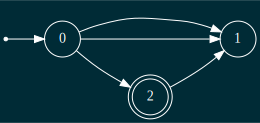

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'blue', 'blue', 'yellow')
{'conjecture': +: {('blue', 'blue', 'blue', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.322035976113078,
 'grad': array([ 0.16134692, -0.15630483,  0.74621843, -0.02347689,  0.20416228,
       -0.02912331,  0.07288305, -0.0304908 ,  0.04108886, -0.03082199,
        0.03338871, -0.0309022 ,  0.03152383, -0.03092163,  0.03107218,
       -0.03092633,  0.03096279, -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.19778484959774}


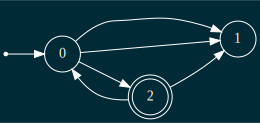

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'blue')
{'conjecture': +: {('blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'yellow'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 11.77248149062347,
 'grad': array([ 0.56982736, -0.55202025,  0.50240319, -0.01625657,  0.24707425,
       -0.02346962,  0.24638683, -0.03043579,  0.03290585, -0.03051298,
        0.03678658, -0.03070903,  0.04549846, -0.0311712 ,  0.032389  ,
       -0.03120925,  0.03178976, -0.03122739,  0.0239631 , -0.03100038,
        0.02924106, -0.03094541,  0.03051932, -0.03093209,  0.0308289 ,
       -0.03092887,  0.03090387, -0.03092808, -0.95877062]),
 'surprisal': 23.54496298124694}


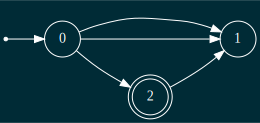

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'green')
{'conjecture': +: {('blue', 'green')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.06817358988092,
 'grad': array([ 0.10820633, -0.10482488,  0.74746391, -0.02346392,  0.20446392,
       -0.02912017,  0.0729561 , -0.03049004,  0.04110656, -0.03082181,
        0.03339299, -0.03090216,  0.03152487, -0.03092162,  0.03107243,
       -0.03092633,  0.03096285, -0.03092747,  0.03093632, -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.13634717976184}


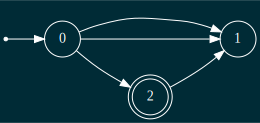

('green', 'blue', 'yellow') 0.6723772939957986
('blue', 'green', 'yellow') 0.6723772939957986
('blue', 'yellow') 0.6807500605657333
('green', 'yellow') 0.9916272334300653
HEREEE ('blue', 'blue', 'blue')
{'conjecture': +: {('blue', 'blue', 'blue')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.320809638806598,
 'grad': array([ 0.15928746, -0.15430972,  0.7462667 , -0.02347639,  0.20417397,
       -0.02912319,  0.        , -0.03049077,  0.04108955, -0.03082198,
        0.        , -0.0309022 ,  0.03152387, -0.03092163,  0.03107219,
       -0.03092633,  0.0309628 , -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.        , -0.03092783, -0.95876288]),
 'surprisal': 18.195332174984777}


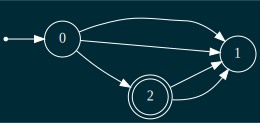

('green', 'blue', 'yellow') 0.6128181859726245
('blue', 'green', 'yellow') 0.6128181859726245
('blue', 'yellow') 0.620449293784828
('green', 'yellow') 0.9923688921877963
HEREEE ('blue', 'green', 'yellow')
{'conjecture': +: {('blue', 'green', 'yellow')}
--------------
-: set(),
 'data': +: {('blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue'),
 ('blue', 'blue', 'blue', 'blue', 'blue', 'blue'),
 ('blue', 'green')}
--------------
-: {('blue', 'green', 'yellow')},
 'energy': 9.320809638806598,
 'grad': array([ 0.15928746, -0.15430972,  0.7462667 , -0.02347639,  0.20417397,
       -0.02912319,  0.07288588, -0.03049077,  0.04108955, -0.03082198,
        0.03338888, -0.0309022 ,  0.03152387, -0.03092163,  0.03107219,
       -0.03092633,  0.0309628 , -0.03092747,  0.0309363 , -0.03092775,
        0.03092989, -0.03092781,  0.03092833, -0.03092783,  0.03092796,
       -0.03092783,  0.03092786, -0.03092783, -0.95876288]),
 'surprisal': 18.195332174984777}


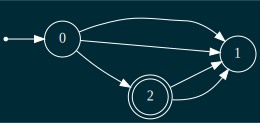

('green', 'blue', 'yellow') 0.6128181859726245
('blue', 'green', 'yellow') 0.6128181859726245
('blue', 'yellow') 0.620449293784828
('green', 'yellow') 0.9923688921877963
prob = 0.306energy = 8.08size = 0.0


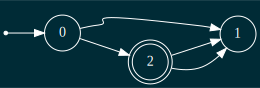

prob = 0.306energy = 8.08size = 0.0


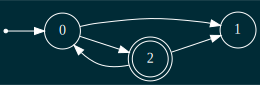

prob = 0.114energy = 9.07size = 0.0


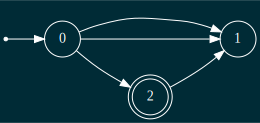

prob = 0.0886energy = 9.32size = 0.223


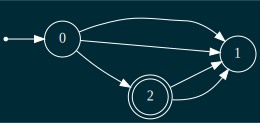

prob = 0.0885energy = 9.32size = 0.223


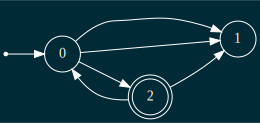

prob = 0.0885energy = 9.32size = 0.223


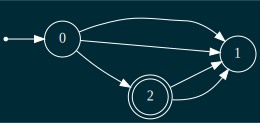

prob = 0.00763energy = 11.8size = 0.0


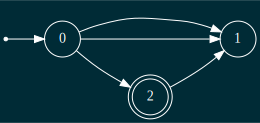

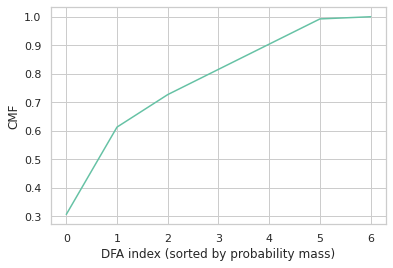

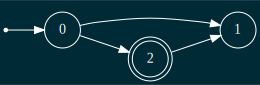

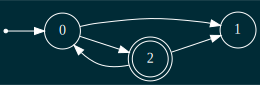

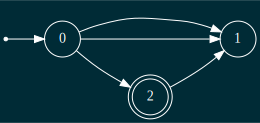

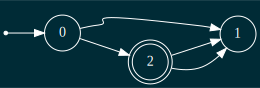

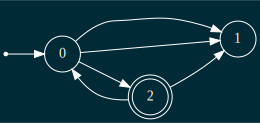

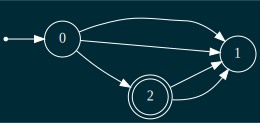

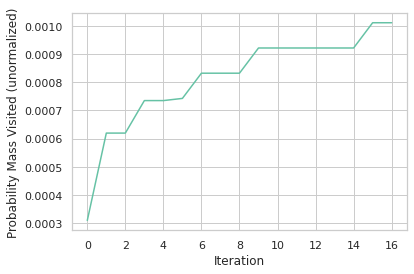

In [118]:
identifer = PartialDFAIdentifier(
    partial = PARTIAL_DFA,
    base_examples = BASE_EXAMPLES,
)

dfa_search = diss(
    demos=[to_demo(TRC4)],
    to_concept=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    lift_path=lambda x: lift_path(x),
    n_iters=n_iters,
    reset_period=4,
    surprise_weight=1/2,  # Rescale surprise to make comparable to size.
    sgs_greed=0,
)

df_greed0 = analyze(dfa_search, n_iters)

In [119]:
df_greed0['treatment'] = 'greed = 0'
df_greed0['iteration'] = df_greed0.index

DISS:   0%|          | 0/20 [00:00<?, ?it/s]

{'energy': 8.241524891247302}


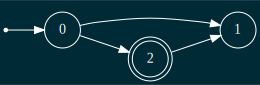

('green', 'blue', 'yellow') 1.0
('blue', 'green', 'yellow') 1.0
('blue', 'yellow') 1.0
('green', 'yellow') 1.0
{'energy': 8.079832190409848}


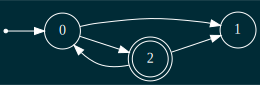

('green', 'blue', 'yellow') 0.9999999999999999
('blue', 'green', 'yellow') 0.9999999999999999
('blue', 'yellow') 0.9999999999999999
('green', 'yellow') 0.9999999999999999
{'energy': 9.06817358988092}


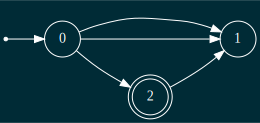

('green', 'blue', 'yellow') 0.8325636981723873
('blue', 'green', 'yellow') 0.8325636981723873
('blue', 'yellow') 0.8325636981723873
('green', 'yellow') 1.0
{'energy': 8.079754616584408}


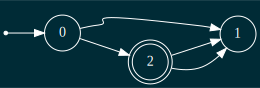

('green', 'blue', 'yellow') 0.8845186033665924
('blue', 'green', 'yellow') 0.8845186033665924
('blue', 'yellow') 0.8845186033665924
('green', 'yellow') 1.0000000000000002
{'energy': 8.440213191118406}


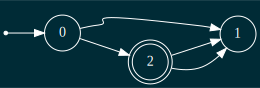

('green', 'blue', 'yellow') 0.9050619840911853
('blue', 'green', 'yellow') 0.9050619840911853
('blue', 'yellow') 0.9050619840911853
('green', 'yellow') 1.0
{'energy': 8.440213191118406}


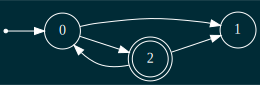

('green', 'blue', 'yellow') 0.9194001645604625
('blue', 'green', 'yellow') 0.9194001645604625
('blue', 'yellow') 0.9194001645604625
('green', 'yellow') 0.9999999999999999
{'energy': 11.77248149062347}


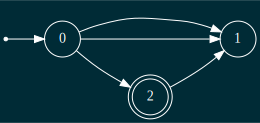

('green', 'blue', 'yellow') 0.9144680100424658
('blue', 'green', 'yellow') 0.9144680100424658
('blue', 'yellow') 0.9198325452123661
('green', 'yellow') 0.9946354648300997
{'energy': 9.322035976113078}


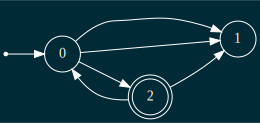

('green', 'blue', 'yellow') 0.860923885855504
('blue', 'green', 'yellow') 0.860923885855504
('blue', 'yellow') 0.8659743156283997
('green', 'yellow') 0.9949495702271043
{'energy': 9.322159122789799}


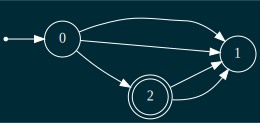

('green', 'blue', 'yellow') 0.8133087254866014
('blue', 'green', 'yellow') 0.8133087254866014
('blue', 'yellow') 0.8180798308877156
('green', 'yellow') 0.9952288945988859
{'energy': 8.301224487412036}


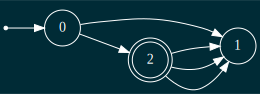

('green', 'blue', 'yellow') 0.8381552370937358
('blue', 'green', 'yellow') 0.8381552370937358
('blue', 'yellow') 0.8422913619579362
('green', 'yellow') 0.9958638751357995
{'energy': 8.301301528216367}


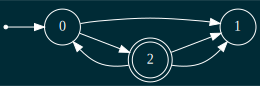

('green', 'blue', 'yellow') 0.8571636820991375
('blue', 'green', 'yellow') 0.8571636820991375
('blue', 'yellow') 0.8608140247816669
('green', 'yellow') 0.9963496573174706
{'energy': 9.320809638806598}


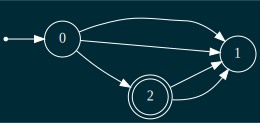

('green', 'blue', 'yellow') 0.8223201536654832
('blue', 'green', 'yellow') 0.8223201536654832
('blue', 'yellow') 0.8258221106642656
('green', 'yellow') 0.9964980430012176
{'energy': 9.291326428578657}


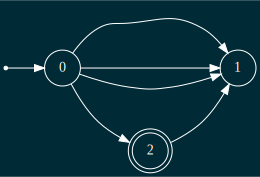

('green', 'blue', 'yellow') 0.7892762172449355
('blue', 'green', 'yellow') 0.7892762172449355
('blue', 'yellow') 0.7926374523558991
('green', 'yellow') 0.9564549796890085
{'energy': 12.033575771918109}


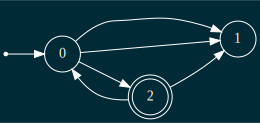

('green', 'blue', 'yellow') 0.787238174766802
('blue', 'green', 'yellow') 0.787238174766802
('blue', 'yellow') 0.7931728969458145
('green', 'yellow') 0.9539852538383644
{'energy': 8.301301528216367}


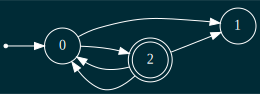

('green', 'blue', 'yellow') 0.8079537137415117
('blue', 'green', 'yellow') 0.8079537137415117
('blue', 'yellow') 0.8133106021457449
('green', 'yellow') 0.9584654761079279
{'energy': 9.320809638806598}


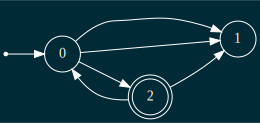

('green', 'blue', 'yellow') 0.7805361534605965
('blue', 'green', 'yellow') 0.7805361534605965
('blue', 'yellow') 0.7857112581707353
('green', 'yellow') 0.959874932235404
{'energy': 11.906638202758028}


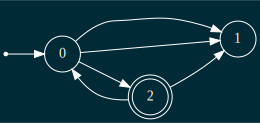

('green', 'blue', 'yellow') 0.7785458676220014
('blue', 'green', 'yellow') 0.7785458676220014
('blue', 'yellow') 0.7862576721277854
('green', 'yellow') 0.9574273512028272
{'energy': 12.033498280181572}


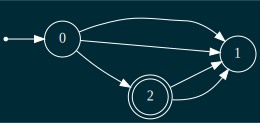

('green', 'blue', 'yellow') 0.7768010998557432
('blue', 'green', 'yellow') 0.7768010998557432
('blue', 'yellow') 0.7867366814443404
('green', 'yellow') 0.9552816993531617
{'energy': 11.906638202758028}


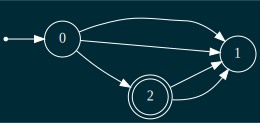

('green', 'blue', 'yellow') 0.774829792383696
('blue', 'green', 'yellow') 0.774829792383696
('blue', 'yellow') 0.7872778850722195
('green', 'yellow') 0.9528574572245208
{'energy': 8.301224487412036}


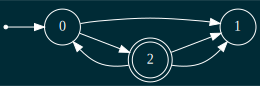

('green', 'blue', 'yellow') 0.7940605083787011
('blue', 'green', 'yellow') 0.7940605083787011
('blue', 'yellow') 0.805445468703016
('green', 'yellow') 0.9568836774824976
prob = 0.107energy = 8.08size = 0.0


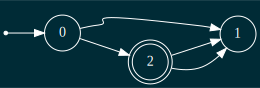

prob = 0.107energy = 8.08size = 0.0


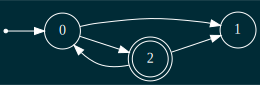

prob = 0.0907energy = 8.24size = -0.288


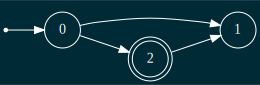

prob = 0.0854energy = 8.3size = 0.223


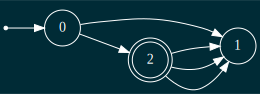

prob = 0.0854energy = 8.3size = 0.223


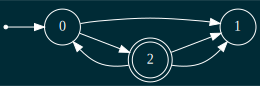

prob = 0.0854energy = 8.3size = 0.223


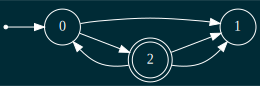

prob = 0.0854energy = 8.3size = 0.223


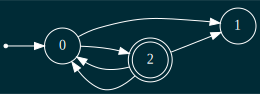

prob = 0.0743energy = 8.44size = 0.0


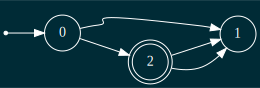

prob = 0.0743energy = 8.44size = 0.0


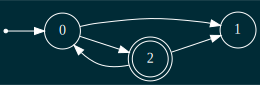

prob = 0.0397energy = 9.07size = 0.0


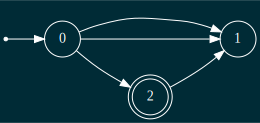

prob = 0.0317energy = 9.29size = 0.223


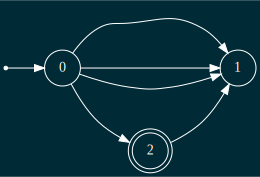

prob = 0.0308energy = 9.32size = 0.223


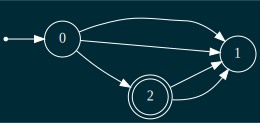

prob = 0.0308energy = 9.32size = 0.223


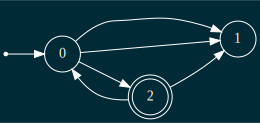

prob = 0.0308energy = 9.32size = 0.223


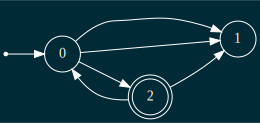

prob = 0.0308energy = 9.32size = 0.223


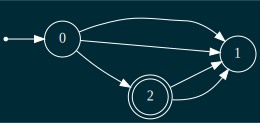

prob = 0.00265energy = 11.8size = 0.0


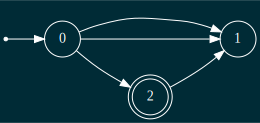

prob = 0.00232energy = 11.9size = 0.223


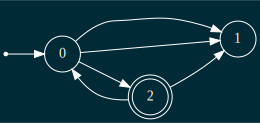

prob = 0.00232energy = 11.9size = 0.223


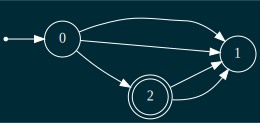

prob = 0.00204energy = 12.0size = 0.223


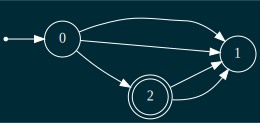

prob = 0.00204energy = 12.0size = 0.223


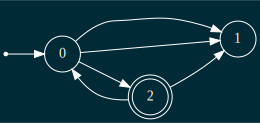

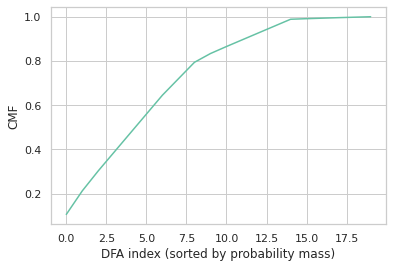

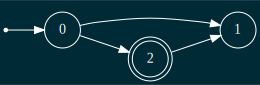

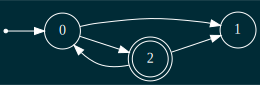

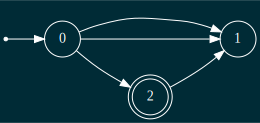

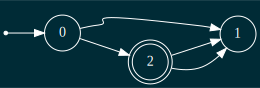

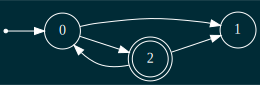

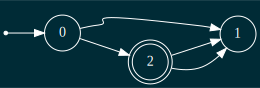

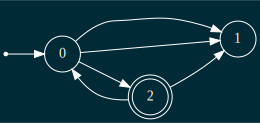

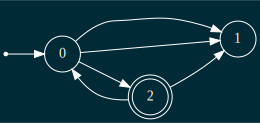

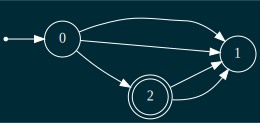

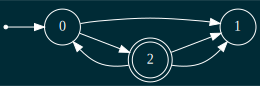

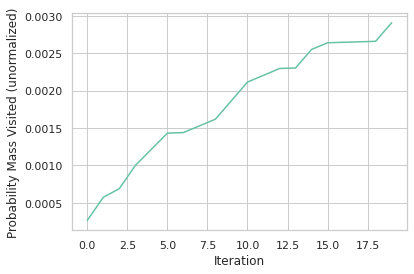

In [120]:
dfa_search = concept_class.enumerative_search(
    demos=[to_demo(TRC4)],
    identifer=identifer,
    to_chain=to_chain,
    competency=lambda *_: 0.8,
    n_iters=n_iters,
    surprise_weight=1/2,  # Rescale surprise to make comparable to size.
)

df3 = analyze(dfa_search, n_iters)

In [121]:
df3['treatment'] = 'enumeration'
df3['iteration'] = df3.index

In [122]:
df = pd.concat([df_greed0, df_greed4, df3], ignore_index=True)

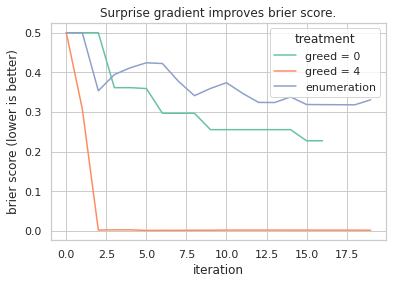

In [123]:
sns.lineplot(data=df, x='iteration', y='brier score', hue='treatment', palette='Set2')
plt.title('Surprise gradient improves brier score.')
plt.ylabel('brier score (lower is better)')
plt.savefig('bs.pgf')

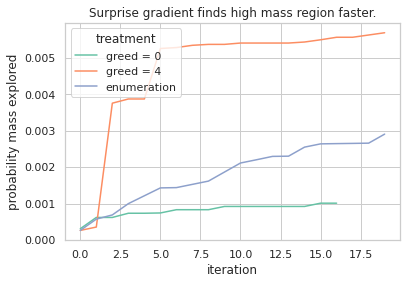

In [124]:
sns.lineplot(data=df, x='iteration', y='probability mass explored', hue='treatment', palette='Set2')
plt.title('Surprise gradient finds high mass region faster.')
plt.savefig('mass.pgf')